# Import Data

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import simulation_helper
import pandas as pd

importlib.reload(simulation_helper)
from simulation_helper import get_fire_data, fit_fire_size_distribution, fit_cox_process,\
    generate_samples, generate_fire_area

from plotting_helper import plot_fire_size_distribution
import plotting_helper
importlib.reload(plotting_helper)
from plotting_helper import plot_fire_size_distribution, plot_fire_count_distribution


In [2]:

all_fires, intensive, extensive = get_fire_data(greater_than_100=True)

c:\Users\LiW\AppData\Local\anaconda3\envs\poisson_fire\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


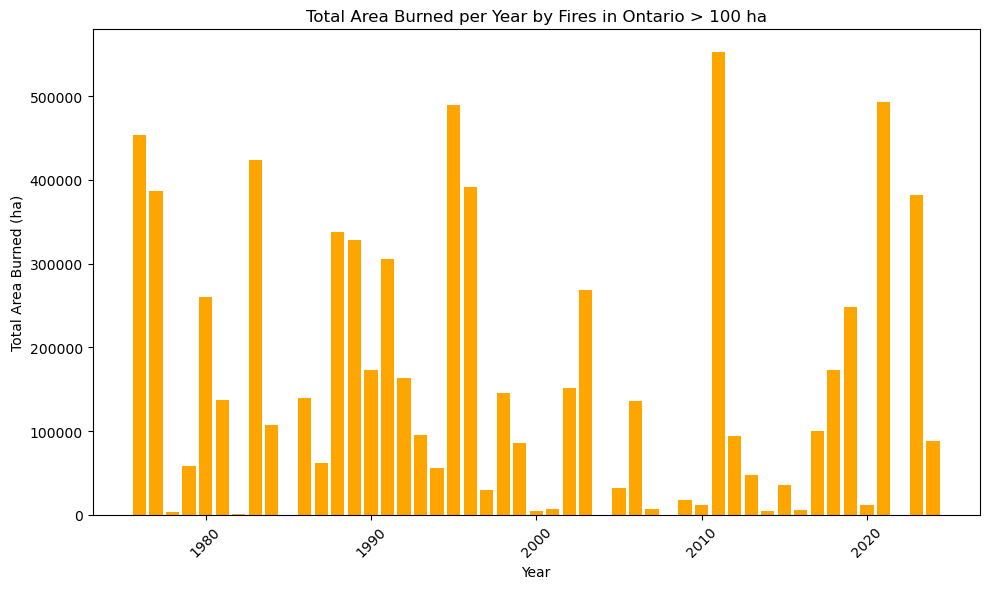

In [3]:
# make batplot of the total area burned per year
total_area_burned = all_fires.groupby('YEAR')['SIZE_HA'].sum().reset_index()
total_area_burned = total_area_burned.rename(columns={'SIZE_HA': 'total_area_burned'})
plt.figure(figsize=(10, 6))
plt.bar(total_area_burned['YEAR'], total_area_burned['total_area_burned'], color='orange')
plt.xlabel('Year')
plt.ylabel('Total Area Burned (ha)')
plt.title('Total Area Burned per Year by Fires in Ontario > 100 ha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Modeling Fire Sizes

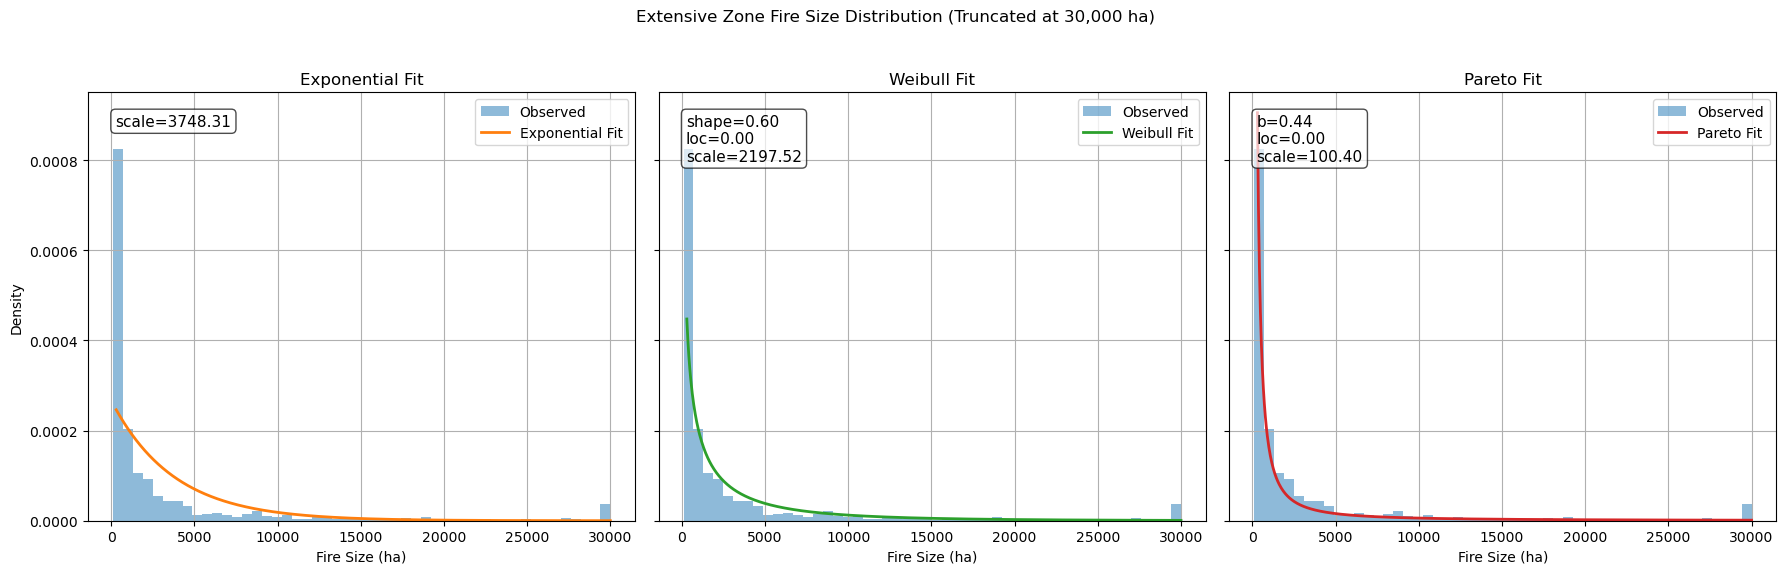

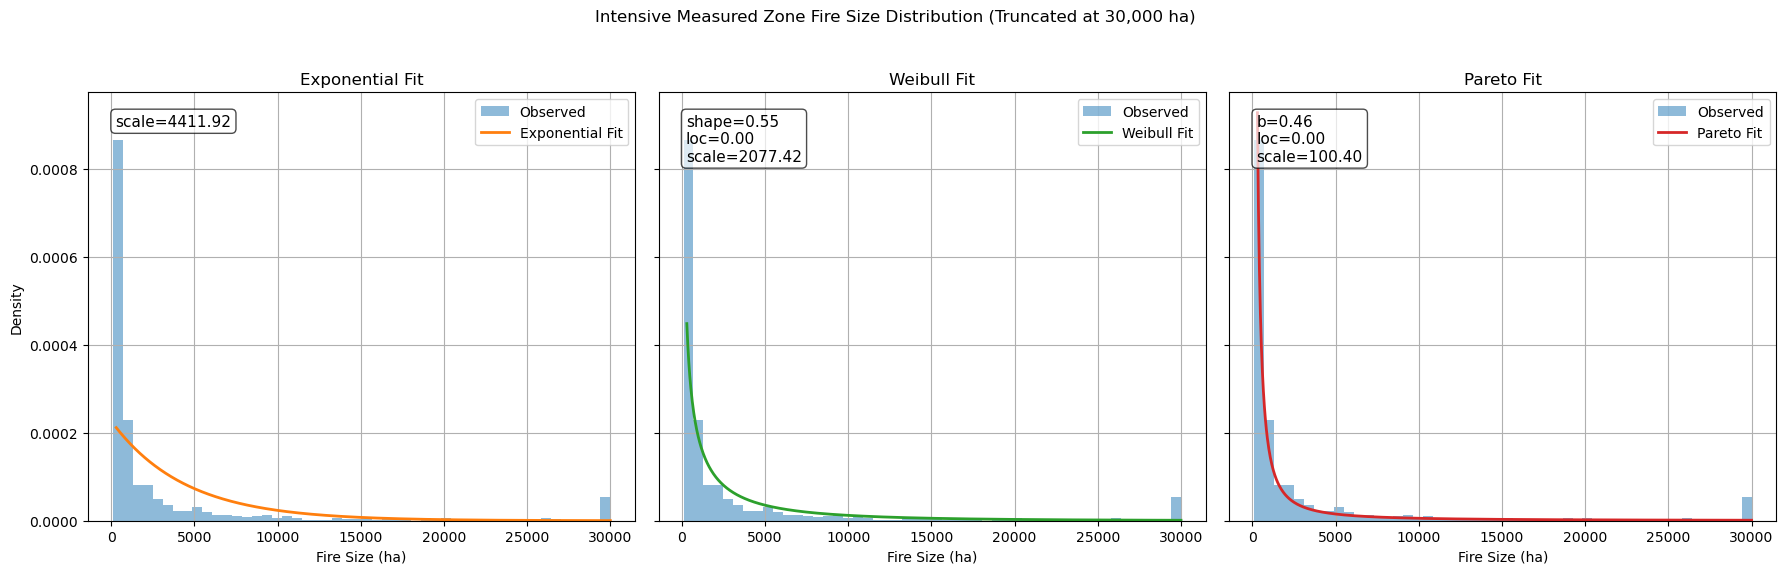

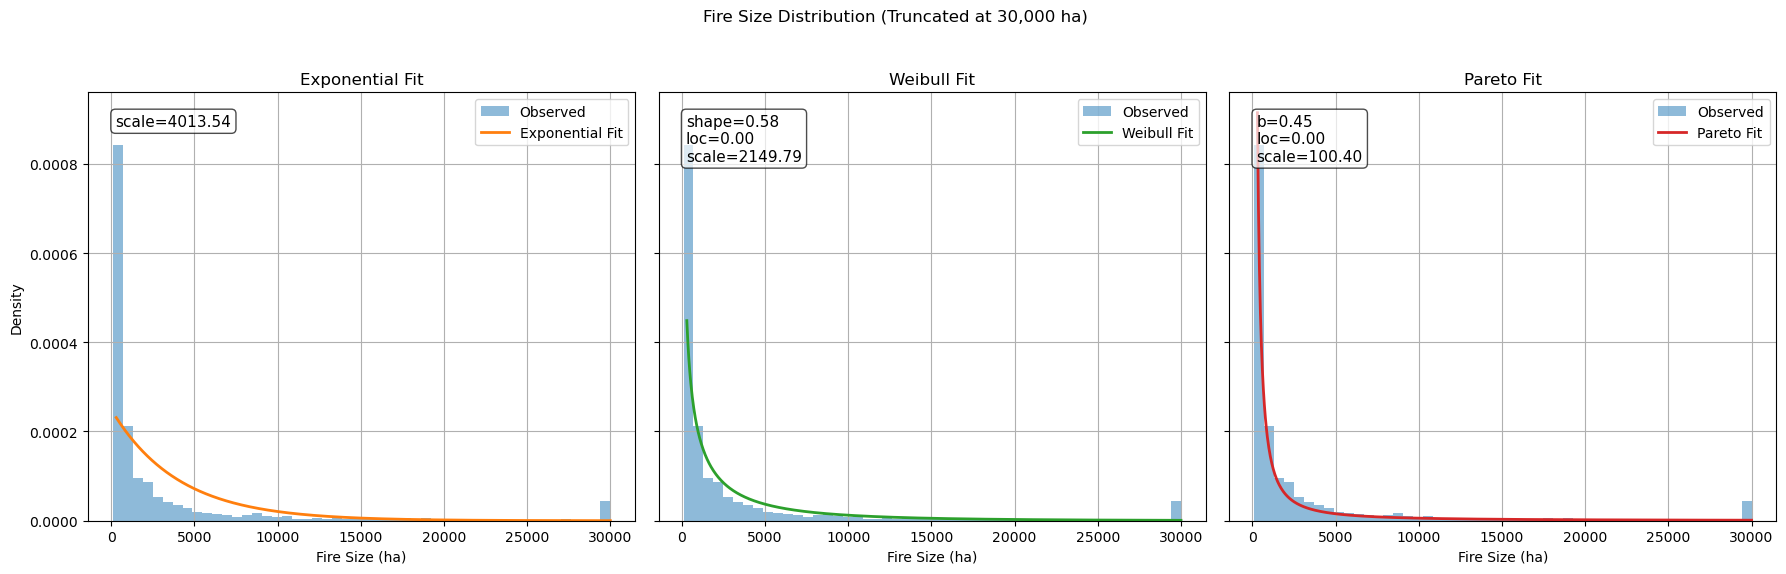

In [63]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(extensive['SIZE_HA'])

plot_fire_size_distribution(extensive['SIZE_HA'], 
                            fire_size_params, 
                            upper_limit=30000, 
                            title='Extensive Zone Fire Size Distribution (Truncated at 30,000 ha)')

fire_size_params = fit_fire_size_distribution(intensive['SIZE_HA'])

plot_fire_size_distribution(intensive['SIZE_HA'], 
                            fire_size_params, 
                            upper_limit=30000, 
                            title='Intensive Measured Zone Fire Size Distribution (Truncated at 30,000 ha)')

fire_size_params = fit_fire_size_distribution(all_fires['SIZE_HA'])

plot_fire_size_distribution(all_fires['SIZE_HA'], 
                            fire_size_params, 
                            upper_limit=30000, 
                            title='Fire Size Distribution (Truncated at 30,000 ha)')

In [5]:

from scipy import stats

pareto_b, pareto_loc, pareto_scale = fire_size_params['pareto']
value = 5000  # example fire size

cdf_val = stats.pareto.cdf(30000, pareto_b, loc=pareto_loc, scale=pareto_scale)
print(cdf_val)

0.9221523898249476


In [10]:
# percentage of all fires less than 30000 ha using actual data
percentage_less_than_30000 = (all_fires['SIZE_HA'] < 30000).mean() * 100
percentage_less_than_30000

np.float64(97.43178170144462)

# Modeling Fire Counts

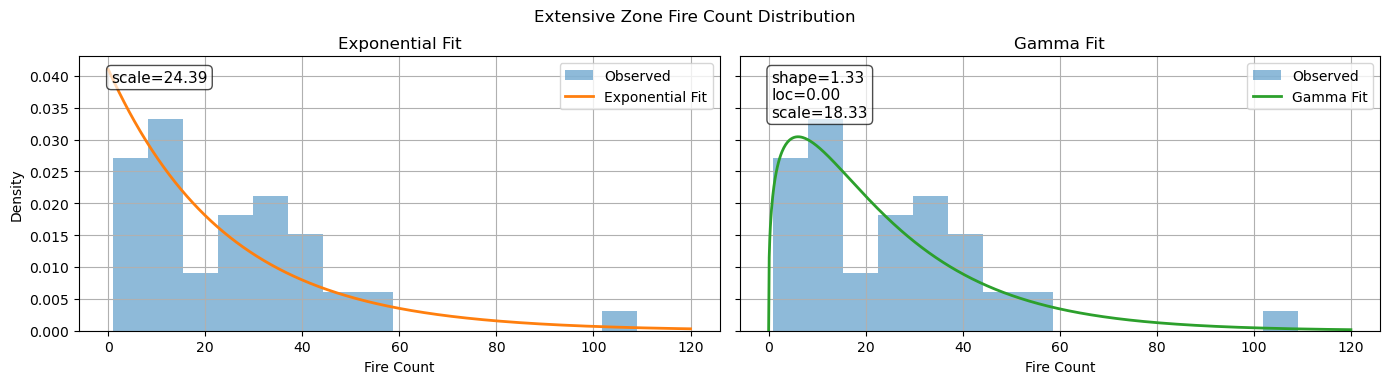

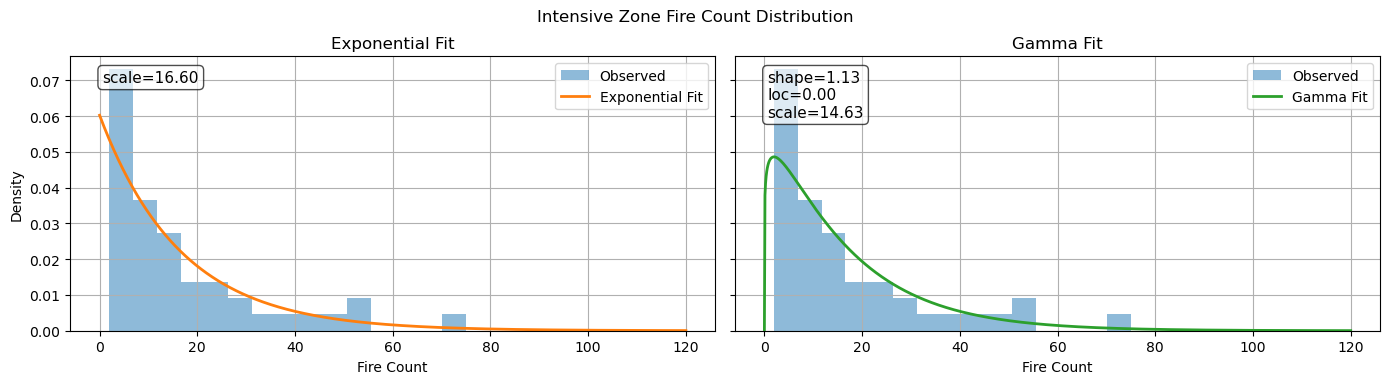

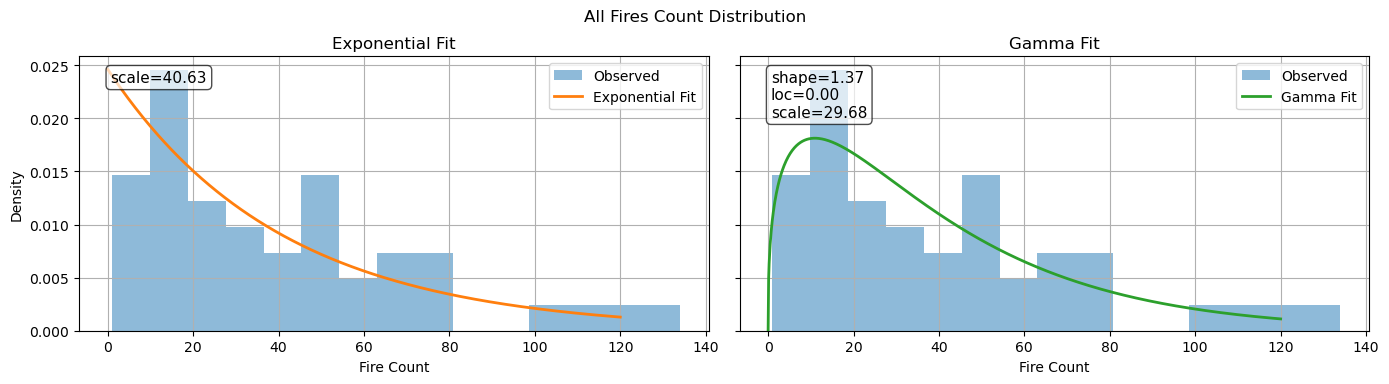

In [56]:
# group by year and get the count of fires
fire_counts_extensive = extensive.groupby('YEAR')['SIZE_HA'].count()
fire_counts_intensive = intensive.groupby('YEAR')['SIZE_HA'].count()
fire_counts_all = all_fires.groupby('YEAR')['SIZE_HA'].count()

# get parameters for Cox process
cox_params = fit_cox_process(fire_counts_extensive)

# plot fire count distribution
plot_fire_count_distribution(fire_counts_extensive, cox_params, title='Extensive Zone Fire Count Distribution')

# get parameters for Cox process for intensive zone
cox_params_intensive = fit_cox_process(fire_counts_intensive)

# plot fire count distribution for intensive zone
plot_fire_count_distribution(fire_counts_intensive, cox_params_intensive, title='Intensive Zone Fire Count Distribution')

# get parameters for Cox process for all fires
cox_params_all = fit_cox_process(fire_counts_all)

# plot fire count distribution for all fires
plot_fire_count_distribution(fire_counts_all, cox_params_all, title='All Fires Count Distribution')

# Simulation

In [75]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(extensive['SIZE_HA'])

# get the number of fires each year
fire_counts = extensive.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['gamma']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_extensive = pd.DataFrame(gamma_cox_simulated_fires)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_extensive_truncated = gamma_cox_simulated_fires_df_extensive

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_extensive_truncated.melt(var_name='distribution', value_name='total_area')


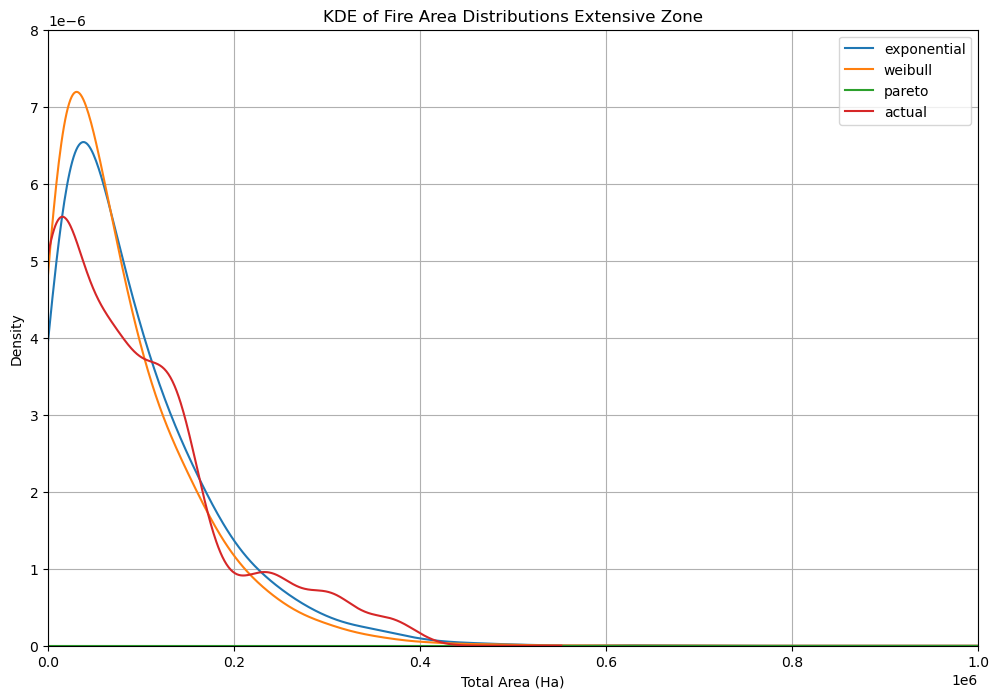

In [66]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = extensive.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions Extensive Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000008)
plt.grid()
plt.show()


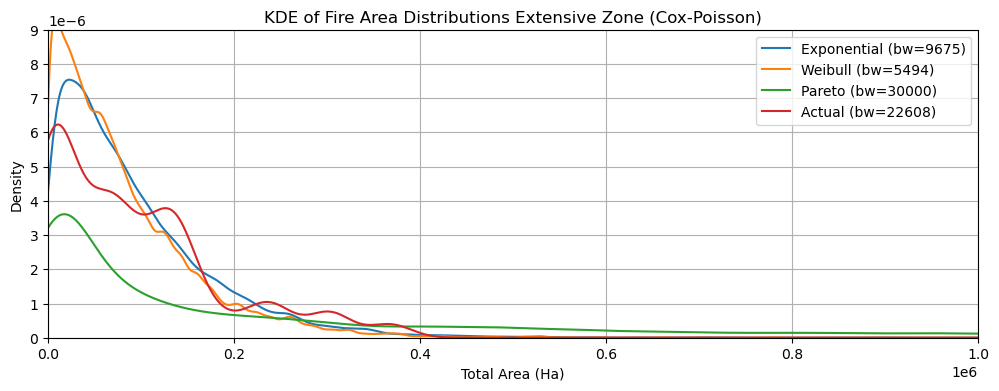

In [54]:
plt.figure(figsize=(12, 4)) 

for distribution in combined_df['distribution'].unique():
    full_data_distribution = combined_df[combined_df['distribution'] == distribution]
    # Remove NaN and values > 1,000,000
    subset = combined_df[
        (combined_df['distribution'] == distribution) &
        (combined_df['total_area'].notna())
    ]['total_area']
    X = subset.values[:, None]
    
    # Define a range of bandwidths to try
    bandwidths = np.logspace(np.log10(5000), np.log10(30000), 20) # Adjust range as needed (e.g., 1e3 to 1e6)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution.capitalize()} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions Extensive Zone (Cox-Poisson)')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

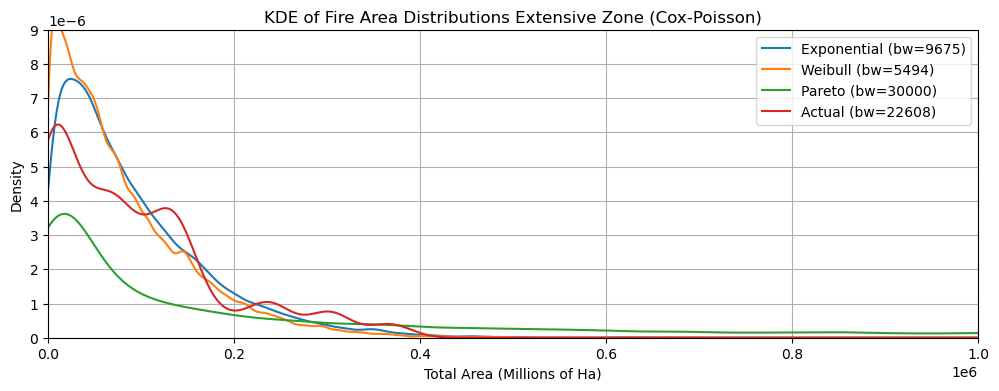

In [74]:
plt.figure(figsize=(12, 4)) 

bandwidth_dict = {
    "exponential": 9675,
    "weibull": 5494,
    "pareto": 30000,
    "actual": 22608
}

for distribution in combined_df['distribution'].unique():
    # Remove NaN and values > 1,000,000
    subset = combined_df[
        (combined_df['distribution'] == distribution) &
        (combined_df['total_area'].notna())
    ]['total_area']
    X = subset.values[:, None]

    # Use specified bandwidth for each distribution
    bw = bandwidth_dict.get(distribution, 10000)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution.capitalize()} (bw={bw:.0f})")

plt.title('KDE of Fire Area Distributions Extensive Zone (Cox-Poisson)')
plt.xlabel('Total Area (Millions of Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

# Intensive Zone

In [35]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(intensive['SIZE_HA'])

# get the number of fires each year
fire_counts = intensive.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires_intensive = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['gamma']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_intensive = pd.DataFrame(gamma_cox_simulated_fires_intensive)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_intensive_truncated = gamma_cox_simulated_fires_df_intensive

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_intensive_truncated.melt(var_name='distribution', value_name='total_area')

# Melt the DataFrame to long format
#long_df = gamma_cox_simulated_fires_df.melt(var_name='distribution', value_name='total_area')


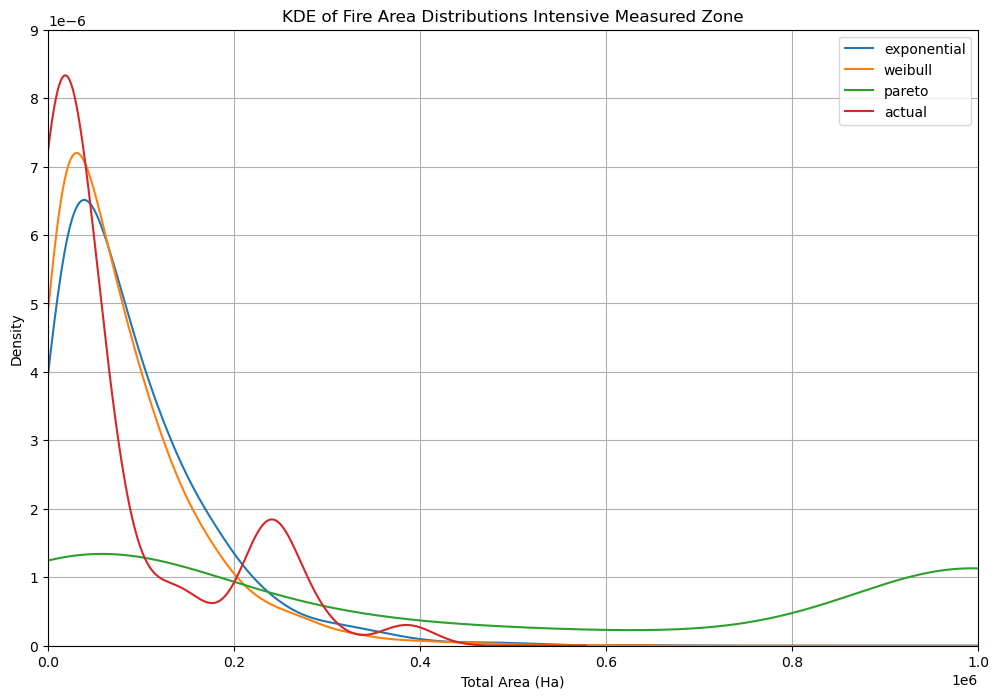

In [ ]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = intensive.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions Intensive Measured Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()


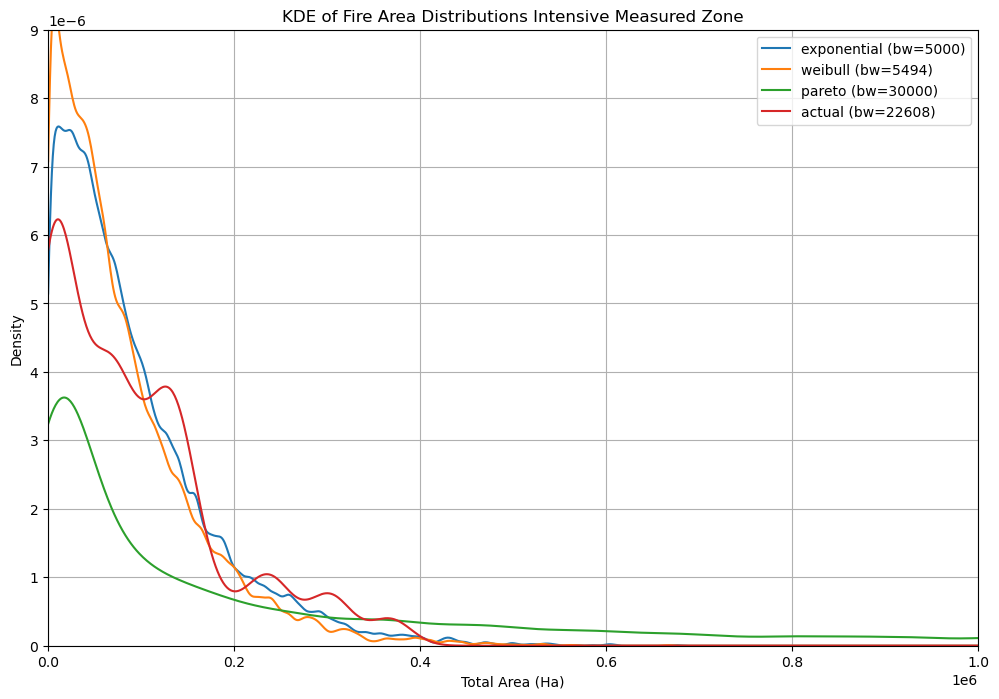

In [36]:
# ...existing code...

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np

plt.figure(figsize=(12, 8))

for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]['total_area'].dropna()
    X = subset.values[:, None]

    # Define a range of bandwidths to try
    bandwidths = np.logspace(np.log10(5000), np.log10(30000), 20)  # 1e3 to 1e6, adjust if needed
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions Intensive Measured Zone')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()
# ...existing code...

# All Zones

In [ ]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(all_fires['SIZE_HA'])

# get the number of fires each year
fire_counts = all_fires.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires_all = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['gamma']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_all = pd.DataFrame(gamma_cox_simulated_fires_all)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_all_truncated = gamma_cox_simulated_fires_df_all.clip(upper=1000000)

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_all_truncated.melt(var_name='distribution', value_name='total_area')



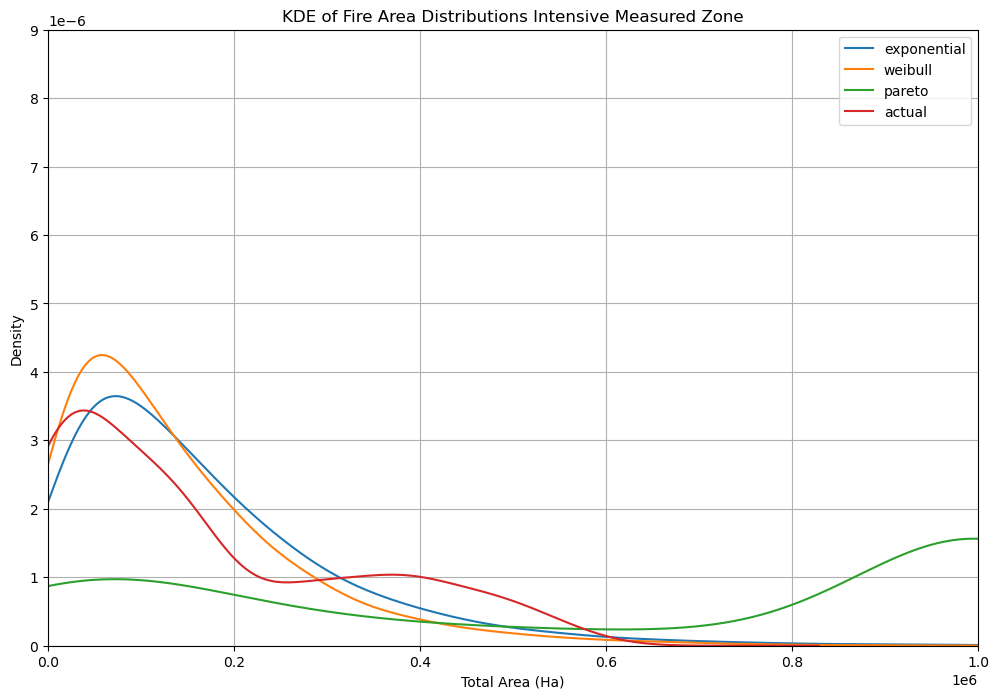

In [ ]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = all_fires.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions All Zones')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()


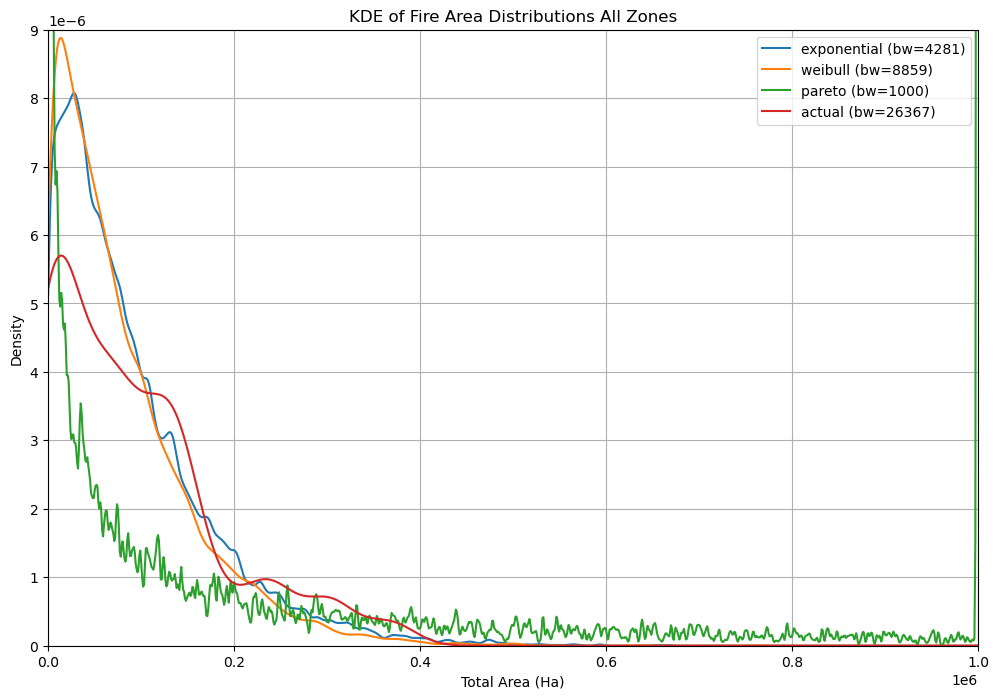

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np

plt.figure(figsize=(12, 8))

for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]['total_area'].dropna()
    X = subset.values[:, None]

    # Define a range of bandwidths to try
    bandwidths = np.logspace(3, 6, 20)  # 1e3 to 1e6, adjust if needed
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions All Zones')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

# simulation just poisson

In [76]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(extensive['SIZE_HA'])

# get the number of fires each year
fire_counts = extensive.groupby('YEAR').size()

# get parameters for the Cox process (contains constant lambda too)
cox_params = fit_cox_process(fire_counts)

# generate samples using constant lambda (Poisson process)
simulated_number_fires = generate_samples(cox_params, size=10000)
poisson_simulated_fires_all = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['constant']]

# Convert list of dicts to DataFrame
poisson_simulated_fires_df_all = pd.DataFrame(poisson_simulated_fires_all)

# truncate all values to 1000000
poisson_simulated_fires_df_all_truncated = poisson_simulated_fires_df_all

# Melt the DataFrame to long format
long_df_poisson = poisson_simulated_fires_df_all_truncated.melt(var_name='distribution', value_name='total_area')

In [77]:
# Concatenate Poisson simulation and actual data
actual_grouped = extensive.groupby('YEAR')['SIZE_HA'].sum().reset_index()
actual_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
actual_grouped['distribution'] = 'actual'
actual_grouped.drop(columns='YEAR', inplace=True)

combined_poisson_df = pd.concat([long_df_poisson, actual_grouped], ignore_index=True)

# KDE plot with bandwidth selection
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for distribution in combined_poisson_df['distribution'].unique():
    subset = combined_poisson_df[combined_poisson_df['distribution'] == distribution]['total_area'].dropna()
    X = subset.values[:, None]

    bandwidths = np.logspace(np.log10(10000), np.log10(30000), 20)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions (Poisson Simulation vs Actual)')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

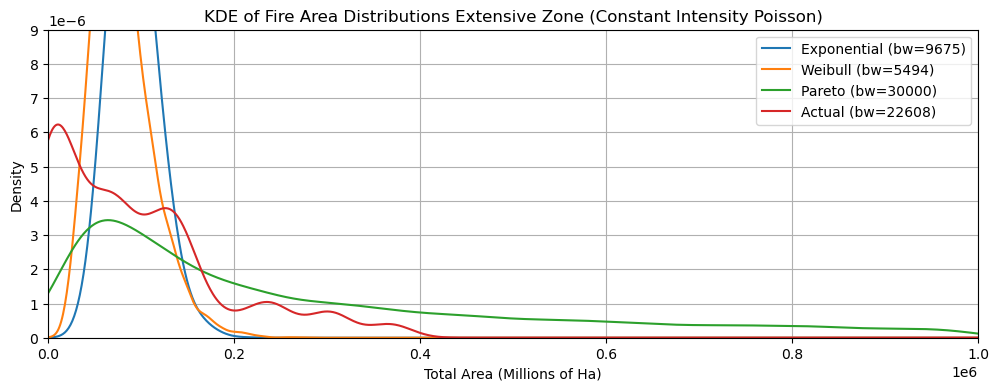

In [79]:
plt.figure(figsize=(12, 4))

bandwidth_dict = {
    "exponential": 9675,
    "weibull": 5494,
    "pareto": 30000,
    "actual": 22608
}

for distribution in combined_poisson_df['distribution'].unique():
    # Remove NaN and values > 1,000,000 if needed
    subset = combined_poisson_df[
        (combined_poisson_df['distribution'] == distribution) &
        (combined_poisson_df['total_area'].notna()) &
        (combined_poisson_df['total_area'] <= 1_000_000)
    ]['total_area']
    X = subset.values[:, None]

    # Use specified bandwidth for each distribution
    bw = bandwidth_dict.get(distribution, 10000)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution.capitalize()} (bw={bw:.0f})")

plt.title('KDE of Fire Area Distributions Extensive Zone (Constant Intensity Poisson)')
plt.xlabel('Total Area (Millions of Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

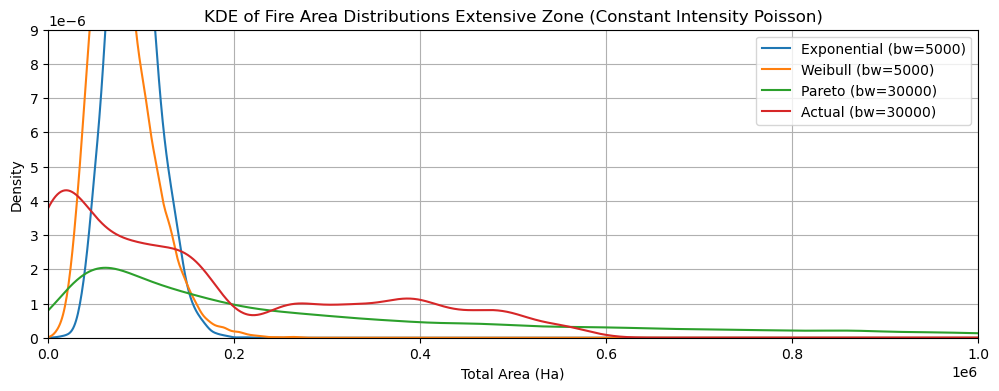

In [53]:
# Concatenate Poisson simulation and actual data
actual_grouped = all_fires.groupby('YEAR')['SIZE_HA'].sum().reset_index()
actual_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
actual_grouped['distribution'] = 'actual'
actual_grouped.drop(columns='YEAR', inplace=True)

combined_poisson_df = pd.concat([long_df_poisson, actual_grouped], ignore_index=True)

plt.figure(figsize=(12, 4))  # Make the graph more narrow

for distribution in combined_poisson_df['distribution'].unique():
    # Remove NaN and values > 1,000,000
    subset = combined_poisson_df[
        (combined_poisson_df['distribution'] == distribution) &
        (combined_poisson_df['total_area'].notna())
    ]['total_area']
    X = subset.values[:, None]

    bandwidths = np.logspace(np.log10(5000), np.log10(30000), 20)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=5)
    grid.fit(X)

    best_bandwidth = grid.best_params_['bandwidth']
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(X)

    x_d = np.linspace(0, 1000000, 1000)
    log_dens = kde.score_samples(x_d[:, None])
    plt.plot(x_d, np.exp(log_dens), label=f"{distribution.capitalize()} (bw={best_bandwidth:.0f})")

plt.title('KDE of Fire Area Distributions Extensive Zone (Constant Intensity Poisson)')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()

# Temporal Trend

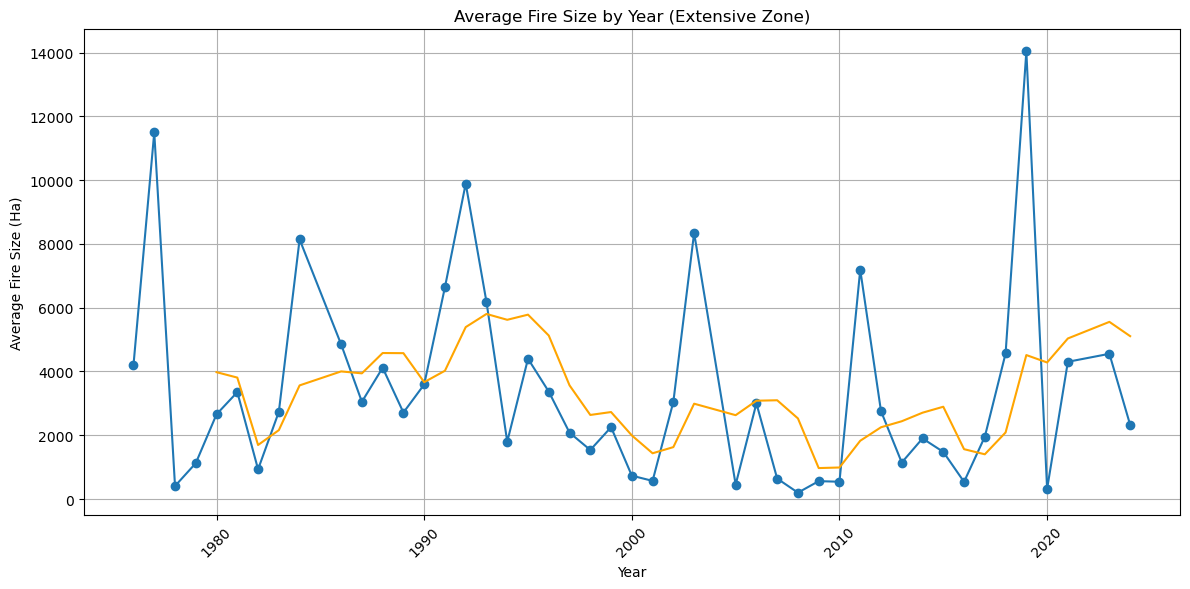

In [ ]:
# average fire size by year
average_fire_size_extensive = extensive.groupby('YEAR')['SIZE_HA'].mean().reset_index()

# plot average fire size by year 
plt.figure(figsize=(12, 6))
plt.plot(average_fire_size_extensive['YEAR'], average_fire_size_extensive['SIZE_HA'], marker='o', linestyle='-')
# plot a moving average
average_fire_size_extensive['SIZE_HA_MA'] = average_fire_size_extensive['SIZE_HA'].rolling(window=5).mean()
plt.plot(average_fire_size_extensive['YEAR'], average_fire_size_extensive['SIZE_HA_MA'], color='orange', label='5-Year Moving Average')
plt.title('Average Fire Size by Year (Extensive Zone)')
plt.xlabel('Year')
plt.ylabel('Average Fire Size (Ha)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


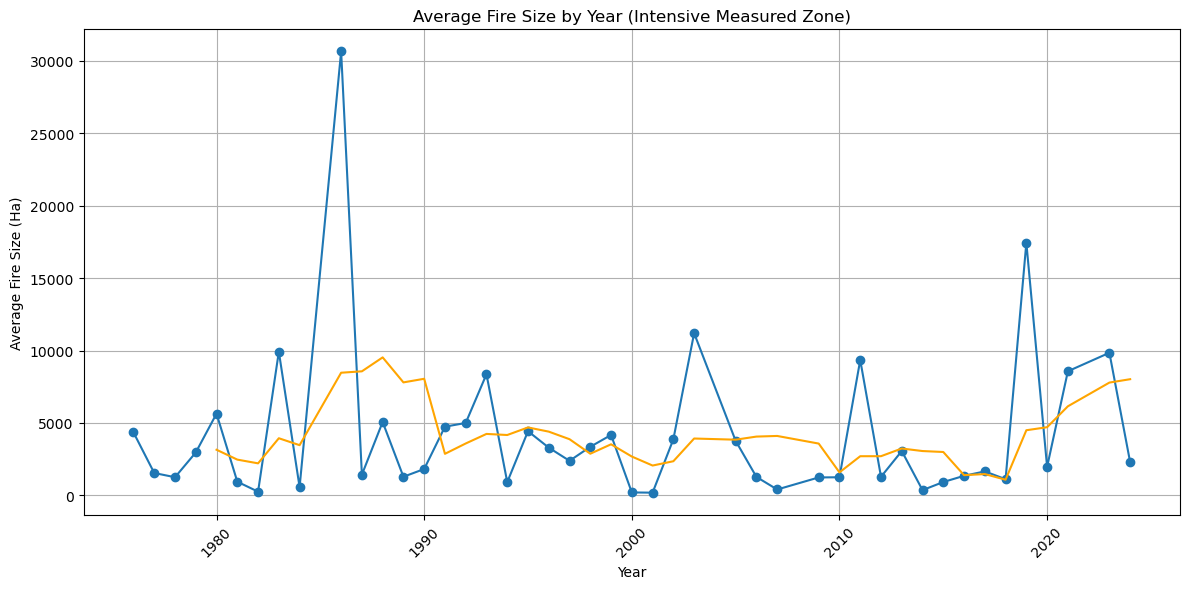

In [ ]:
# Do the same for intensive zone
average_fire_size_intensive = intensive.groupby('YEAR')['SIZE_HA'].mean().reset_index()
# plot average fire size by year
plt.figure(figsize=(12, 6))
plt.plot(average_fire_size_intensive['YEAR'], average_fire_size_intensive['SIZE_HA'], marker='o', linestyle='-')
# plot a moving average
average_fire_size_intensive['SIZE_HA_MA'] = average_fire_size_intensive['SIZE_HA'].rolling(window=5).mean()
plt.plot(average_fire_size_intensive['YEAR'], average_fire_size_intensive['SIZE_HA_MA'], color='orange', label='5-Year Moving Average')
plt.title('Average Fire Size by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Average Fire Size (Ha)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\LiW\AppData\Local\Temp\ipykernel_10224\568630211.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_per_year, labels=years_full)


C:\Users\LiW\AppData\Local\Temp\ipykernel_10224\568630211.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_per_year, labels=years_full)


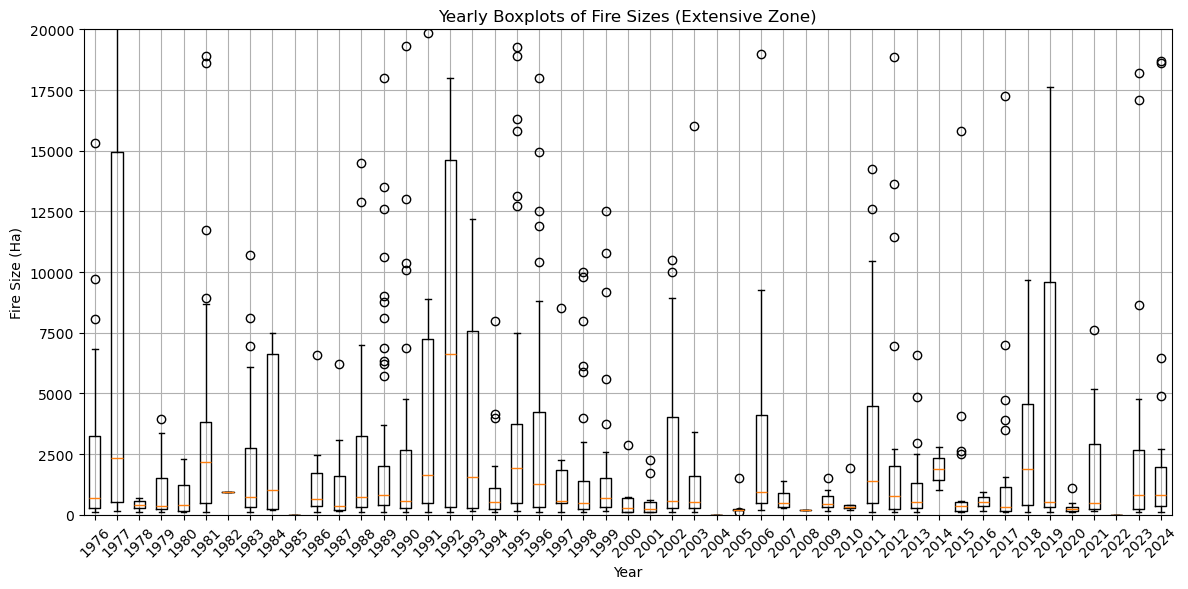

In [36]:
# make yearly boxplots of the fire sizes for extensive zone
plt.figure(figsize=(12, 6))
# Get the full range of years (including years with no fires)
years_full = np.arange(extensive['YEAR'].min(), extensive['YEAR'].max() + 1)
data_per_year = [
extensive[extensive['YEAR'] == year]['SIZE_HA'].values if year in extensive['YEAR'].values else [0]
    for year in years_full
]
plt.boxplot(data_per_year, labels=years_full)
plt.title('Yearly Boxplots of Fire Sizes (Extensive Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


C:\Users\LiW\AppData\Local\Temp\ipykernel_23896\3809511070.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_per_year, labels=years_full, showfliers=False)


C:\Users\LiW\AppData\Local\Temp\ipykernel_23896\3809511070.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_per_year, labels=years_full, showfliers=False)


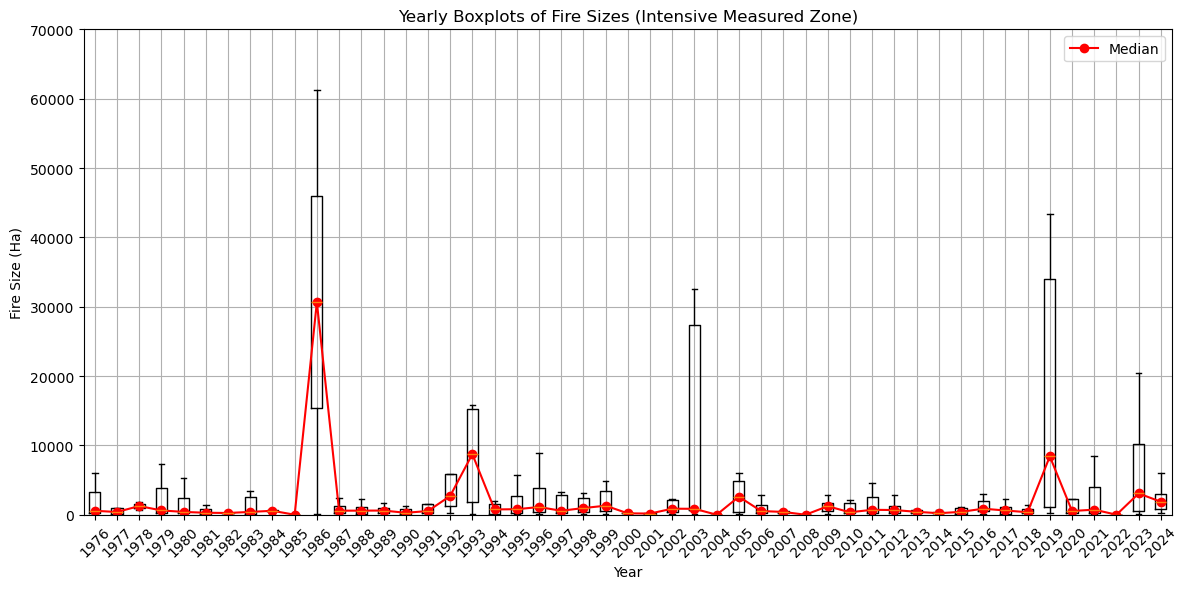

In [14]:
# make yearly boxplots of the fire sizes for extensive zone
plt.figure(figsize=(12, 6))
# Get the full range of years (including years with no fires)
years_full = np.arange(intensive['YEAR'].min(), intensive['YEAR'].max() + 1)
data_per_year = [
    intensive[intensive['YEAR'] == year]['SIZE_HA'].values if year in intensive['YEAR'].values else [0]
    for year in years_full
]
plt.boxplot(data_per_year, labels=years_full)
plt.title('Yearly Boxplots of Fire Sizes (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.show()


In [30]:
extensive[extensive['YEAR'] == 2021]

,YEAR,REP_DATE,SIZE_HA,FMZ_ZONE,SEASON,AFTER_2005,SIZE_HA_100
425181,2021,2021-07-18,441.700012,Extensive,Summer,After 2005,True
425211,2021,2021-08-03,156.300003,Extensive,Summer,After 2005,True
425265,2021,2021-07-26,980.500000,Extensive,Summer,After 2005,True
425329,2021,2021-06-23,316.299988,Extensive,Summer,After 2005,True
425429,2021,2021-07-16,191.199997,Extensive,Summer,After 2005,True
426711,2021,2021-07-06,150.000000,Extensive,Summer,After 2005,True
426804,2021,2021-07-12,2909.500000,Extensive,Summer,After 2005,True
426885,2021,2021-07-01,478.600006,Extensive,Summer,After 2005,True
427243,2021,2021-06-06,368.500000,Extensive,Summer,After 2005,True
428650,2021,2021-07-12,3627.899902,Extensive,Summer,After 2005,True


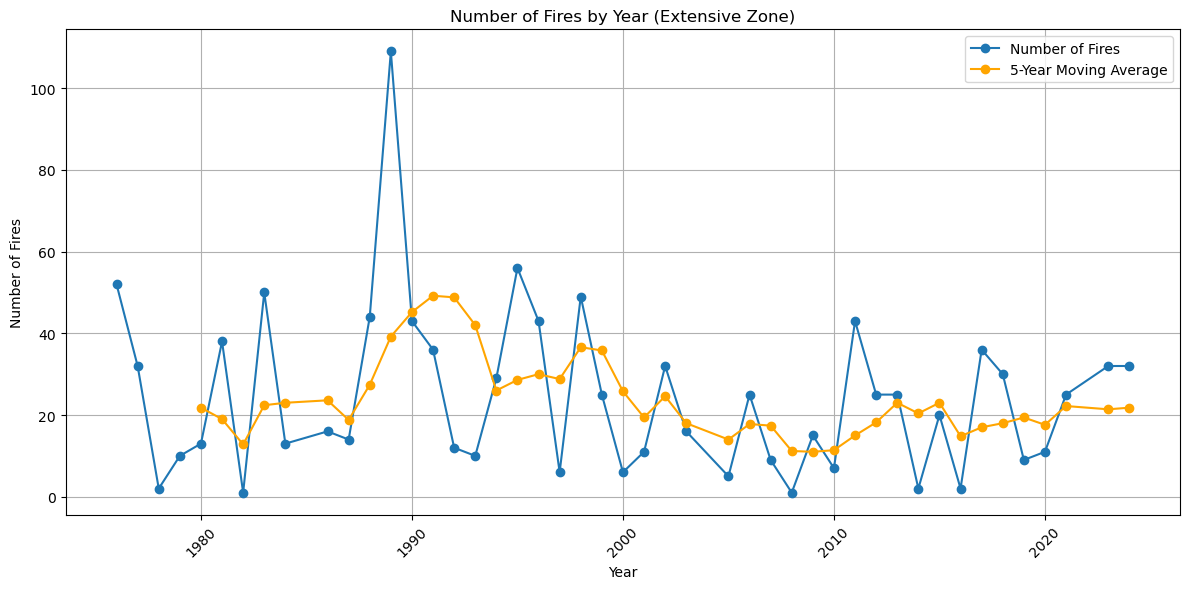

In [ ]:
# number of fires by year and then do a moving average too
# number of fires by year
fire_counts_extensive = extensive.groupby('YEAR')['SIZE_HA'].count().reset_index()
# calculate moving average
fire_counts_extensive['moving_average'] = fire_counts_extensive['SIZE_HA'].rolling(window=5).mean()
# plot number of fires by year and moving average
plt.figure(figsize=(12, 6))
plt.plot(fire_counts_extensive['YEAR'], fire_counts_extensive['SIZE_HA'], marker='o', linestyle='-', label='Number of Fires')
plt.plot(fire_counts_extensive['YEAR'], fire_counts_extensive['moving_average'], marker='o', linestyle='-', color='orange', label='5-Year Moving Average')
plt.title('Number of Fires by Year (Extensive Zone)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

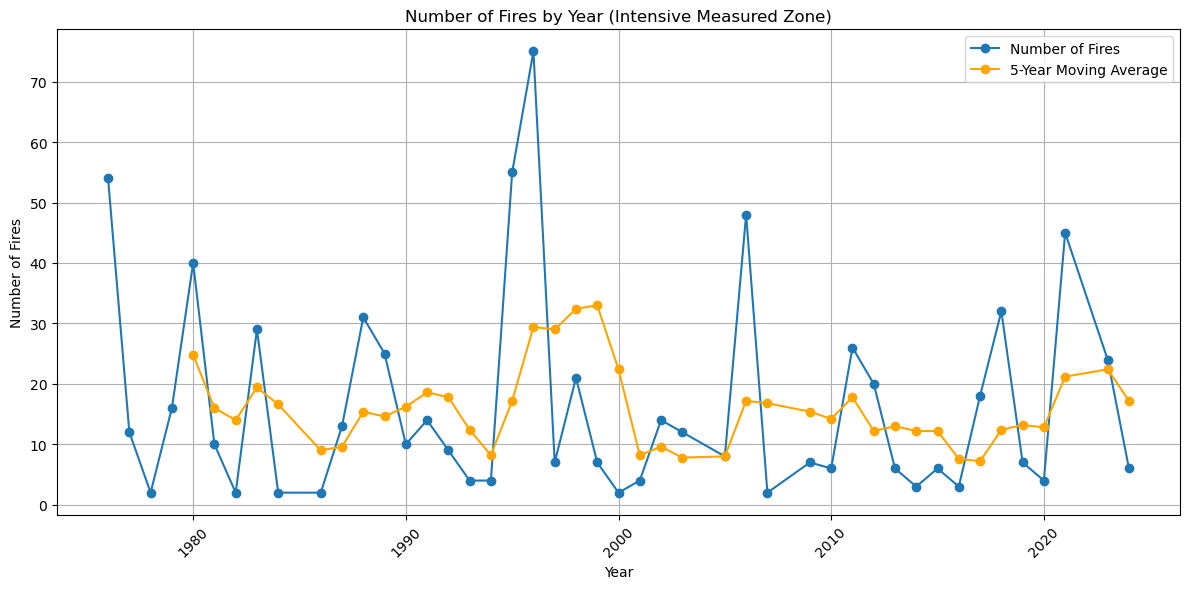

In [ ]:
# dop the same for the intensive zone
# number of fires by year
fire_counts_intensive = intensive.groupby('YEAR')['SIZE_HA'].count().reset_index()
# calculate moving average
fire_counts_intensive['moving_average'] = fire_counts_intensive['SIZE_HA'].rolling(window=5).mean()
# plot number of fires by year and moving average
plt.figure(figsize=(12, 6))
plt.plot(fire_counts_intensive['YEAR'], fire_counts_intensive['SIZE_HA'], marker='o', linestyle='-', label='Number of Fires')
plt.plot(fire_counts_intensive['YEAR'], fire_counts_intensive['moving_average'], marker='o', linestyle='-', color='orange', label='5-Year Moving Average')
plt.title('Number of Fires by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Simnulation with fixed lambda intensity

In [22]:
# get parameters for fire size distribution
fire_size_params = fit_fire_size_distribution(all_fires['SIZE_HA'])

# get the number of fires each year
fire_counts = all_fires.groupby('YEAR').size()

# get parameters for the Cox process
cox_params = fit_cox_process(fire_counts)

# generate samples
simulated_number_fires = generate_samples(cox_params, size=10000)

# apply generate_fire_area to the simulated number of fires
gamma_cox_simulated_fires_all = [generate_fire_area(x, fire_size_params) for x in simulated_number_fires['constant']]

# Convert list of dicts to DataFrame
gamma_cox_simulated_fires_df_all = pd.DataFrame(gamma_cox_simulated_fires_all)

# truncate all values to 1000000
gamma_cox_simulated_fires_df_all_truncated = gamma_cox_simulated_fires_df_all.clip(upper=1000000)

# Melt the DataFrame to long format
long_df = gamma_cox_simulated_fires_df_all_truncated.melt(var_name='distribution', value_name='total_area')


In [17]:
#group extensive by year and sum the total SIZE_HA

extensive_grouped = all_fires.groupby('YEAR')['SIZE_HA'].sum().reset_index()

# add to long df but remove the year and the disteibution is called 'actual'
extensive_grouped.rename(columns={'SIZE_HA': 'total_area'}, inplace=True)
extensive_grouped['distribution'] = 'actual'
# drop the YEAR column
extensive_grouped.drop(columns='YEAR', inplace=True)

# concatenate the two DataFrames
combined_df = pd.concat([long_df, extensive_grouped], ignore_index=True)

# plot kde of the three distributions
plt.figure(figsize=(12, 8))
for distribution in combined_df['distribution'].unique():
    subset = combined_df[combined_df['distribution'] == distribution]
    subset['total_area'].plot.kde(label=distribution, bw_method=0.3)

plt.title('KDE of Fire Area Distributions All Zones')
plt.xlabel('Total Area (Ha)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1000000)
plt.ylim(0, 0.000009)
plt.grid()
plt.show()

NameError: name 'long_df' is not defined

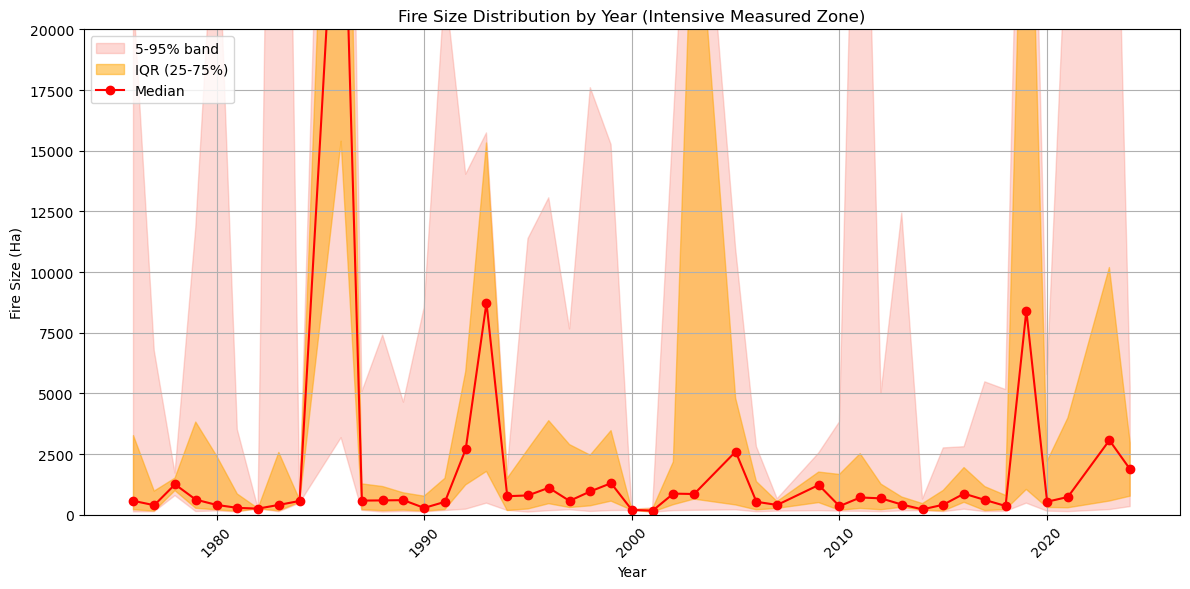

In [16]:
# Plot median, IQR, and 5-95% bands of fire sizes by year for Intensive Measured Zone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Group by year and aggregate statistics
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

plt.figure(figsize=(12, 6))
# 5-95% band
plt.fill_between(stats['YEAR'], stats['p5'], stats['p95'], color='salmon', alpha=0.3, label='5-95% band')
# IQR band
plt.fill_between(stats['YEAR'], stats['q25'], stats['q75'], color='orange', alpha=0.5, label='IQR (25-75%)')
# Median line
plt.plot(stats['YEAR'], stats['median'], color='red', marker='o', label='Median')
plt.title('Fire Size Distribution by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 20000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

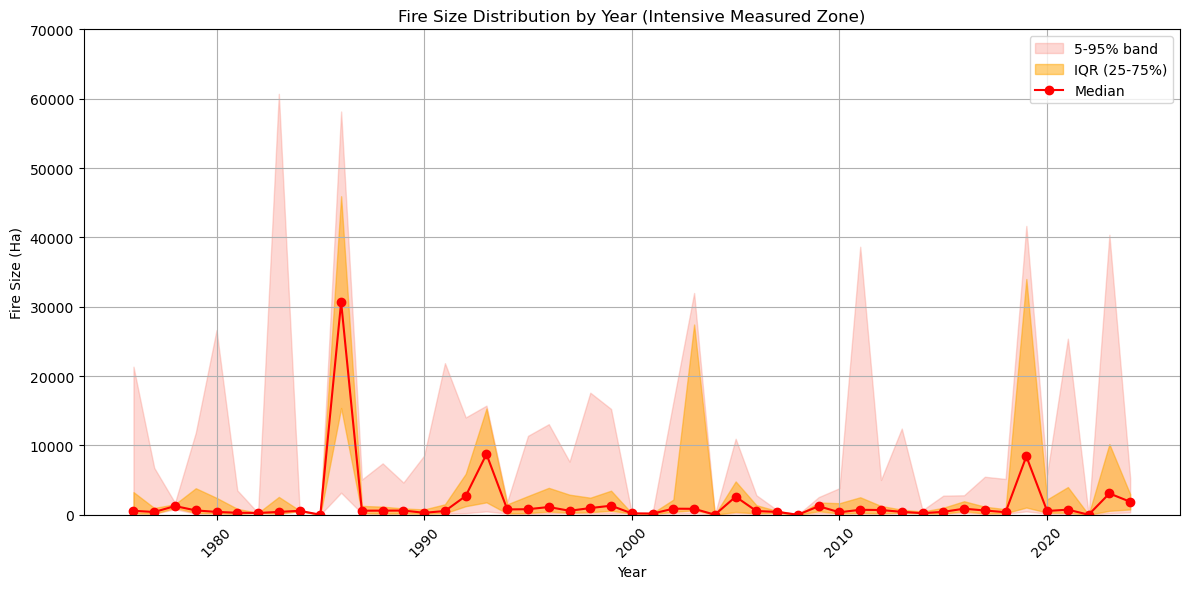

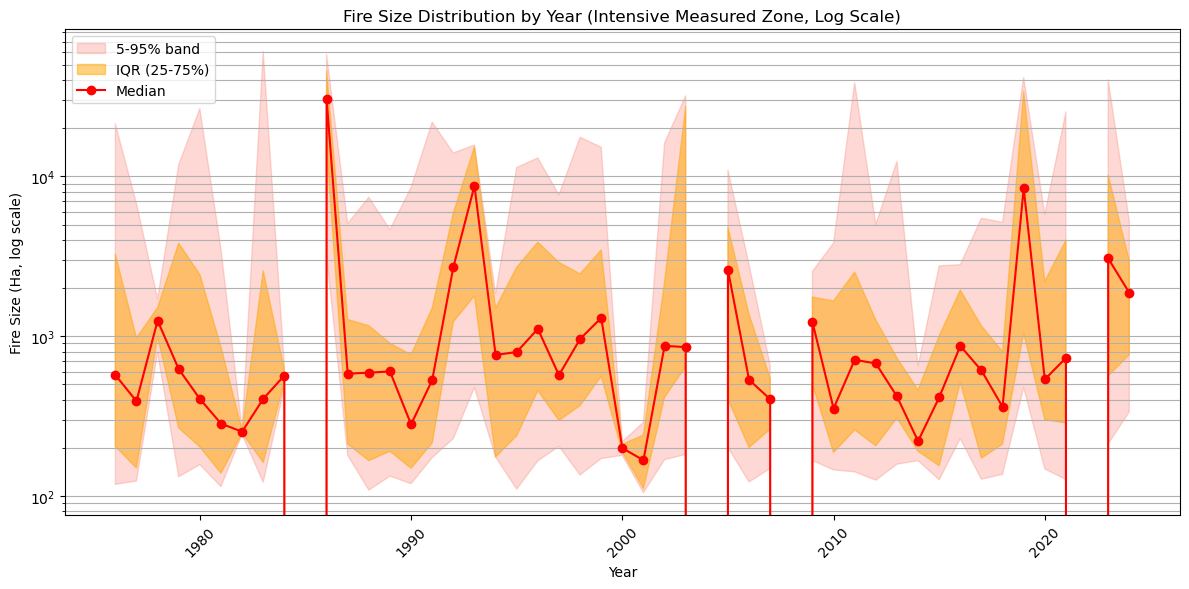

In [19]:
# Plot median, IQR, and 5-95% bands of fire sizes by year for Intensive Measured Zone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Group by year and aggregate statistics
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Add zeroes for years with no fires
all_years = np.arange(intensive['YEAR'].min(), intensive['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

plt.figure(figsize=(12, 6))
# 5-95% band
plt.fill_between(stats['YEAR'], stats['p5'], stats['p95'], color='salmon', alpha=0.3, label='5-95% band')
# IQR band
plt.fill_between(stats['YEAR'], stats['q25'], stats['q75'], color='orange', alpha=0.5, label='IQR (25-75%)')
# Median line
plt.plot(stats['YEAR'], stats['median'], color='red', marker='o', label='Median')
plt.title('Fire Size Distribution by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Plot median, IQR, and 5-95% bands of fire sizes by year for Intensive Measured Zone (log scale)
# Group by year and aggregate statistics
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Add zeroes for years with no fires
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

plt.figure(figsize=(12, 6))
# 5-95% band
plt.fill_between(stats['YEAR'], stats['p5'], stats['p95'], color='salmon', alpha=0.3, label='5-95% band')
# IQR band
plt.fill_between(stats['YEAR'], stats['q25'], stats['q75'], color='orange', alpha=0.5, label='IQR (25-75%)')
# Median line
plt.plot(stats['YEAR'], stats['median'], color='red', marker='o', label='Median')
plt.title('Fire Size Distribution by Year (Intensive Measured Zone, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

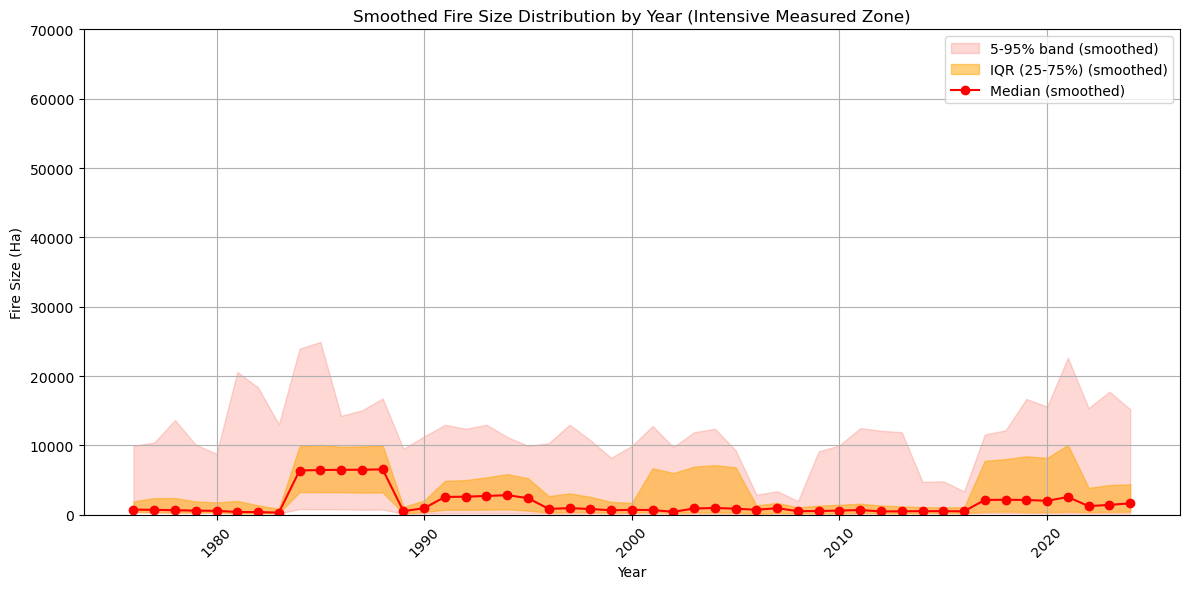

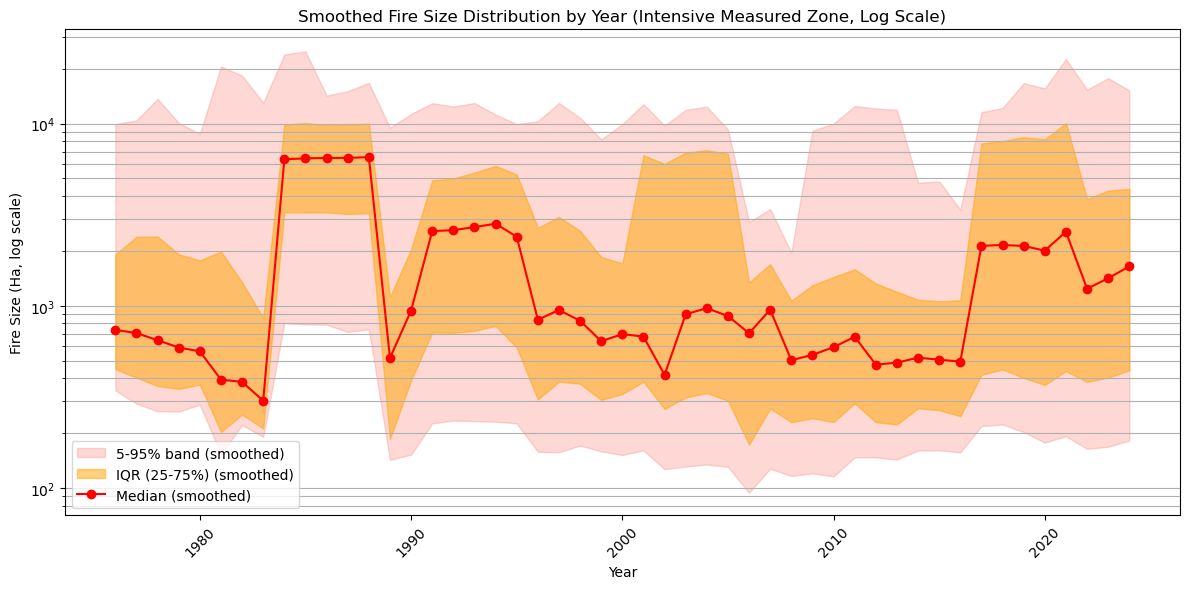

In [20]:
# Smoothed (rolling) 5-95% band, IQR, and median for Intensive Measured Zone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Group by year and aggregate statistics
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Add zeroes for years with no fires
all_years = np.arange(intensive['YEAR'].min(), intensive['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

# Apply rolling window smoothing (5 years)
window = 5
stats_rolled = stats[['median', 'q25', 'q75', 'p5', 'p95']].rolling(window=window, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))
# 5-95% band (smoothed)
plt.fill_between(stats['YEAR'], stats_rolled['p5'], stats_rolled['p95'], color='salmon', alpha=0.3, label='5-95% band (smoothed)')
# IQR band (smoothed)
plt.fill_between(stats['YEAR'], stats_rolled['q25'], stats_rolled['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (smoothed)')
# Median line (smoothed)
plt.plot(stats['YEAR'], stats_rolled['median'], color='red', marker='o', label='Median (smoothed)')
plt.title('Smoothed Fire Size Distribution by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(stats['YEAR'], stats_rolled['p5'], stats_rolled['p95'], color='salmon', alpha=0.3, label='5-95% band (smoothed)')
plt.fill_between(stats['YEAR'], stats_rolled['q25'], stats_rolled['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (smoothed)')
plt.plot(stats['YEAR'], stats_rolled['median'], color='red', marker='o', label='Median (smoothed)')
plt.title('Smoothed Fire Size Distribution by Year (Intensive Measured Zone, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Smoothed (rolling) 5-95% band, IQR, and median for Intensive Measured Zone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Group by year and aggregate statistics
stats = ex.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Add zeroes for years with no fires
all_years = np.arange(intensive['YEAR'].min(), intensive['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

# Apply rolling window smoothing (5 years)
window = 5
stats_rolled = stats[['median', 'q25', 'q75', 'p5', 'p95']].rolling(window=window, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))
# 5-95% band (smoothed)
plt.fill_between(stats['YEAR'], stats_rolled['p5'], stats_rolled['p95'], color='salmon', alpha=0.3, label='5-95% band (smoothed)')
# IQR band (smoothed)
plt.fill_between(stats['YEAR'], stats_rolled['q25'], stats_rolled['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (smoothed)')
# Median line (smoothed)
plt.plot(stats['YEAR'], stats_rolled['median'], color='red', marker='o', label='Median (smoothed)')
plt.title('Smoothed Fire Size Distribution by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(stats['YEAR'], stats_rolled['p5'], stats_rolled['p95'], color='salmon', alpha=0.3, label='5-95% band (smoothed)')
plt.fill_between(stats['YEAR'], stats_rolled['q25'], stats_rolled['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (smoothed)')
plt.plot(stats['YEAR'], stats_rolled['median'], color='red', marker='o', label='Median (smoothed)')
plt.title('Smoothed Fire Size Distribution by Year (Intensive Measured Zone, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

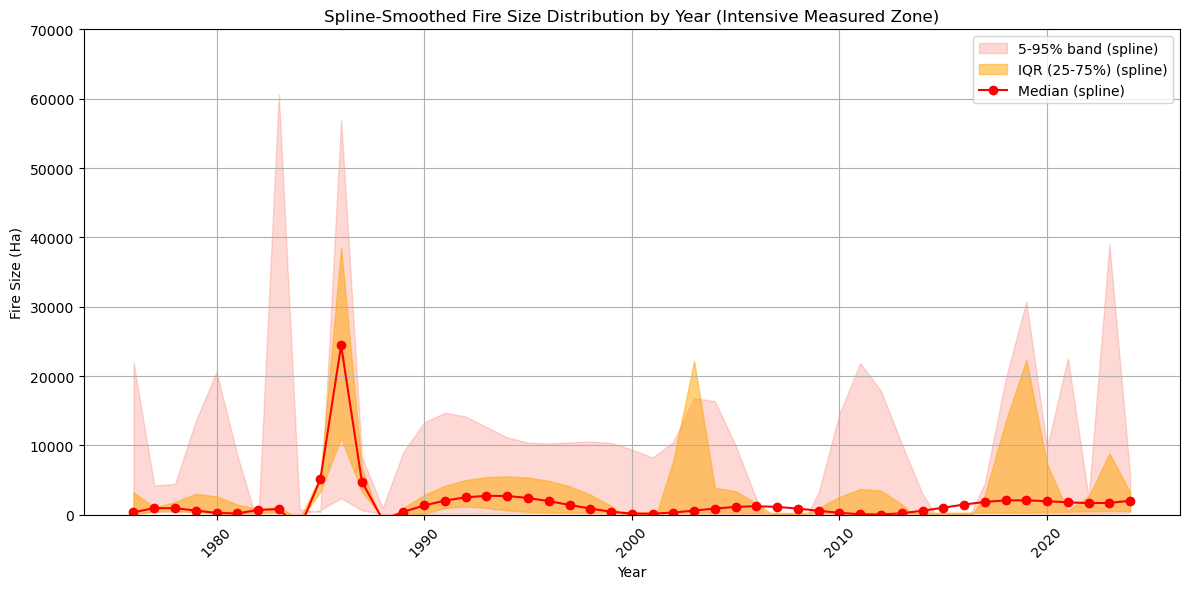

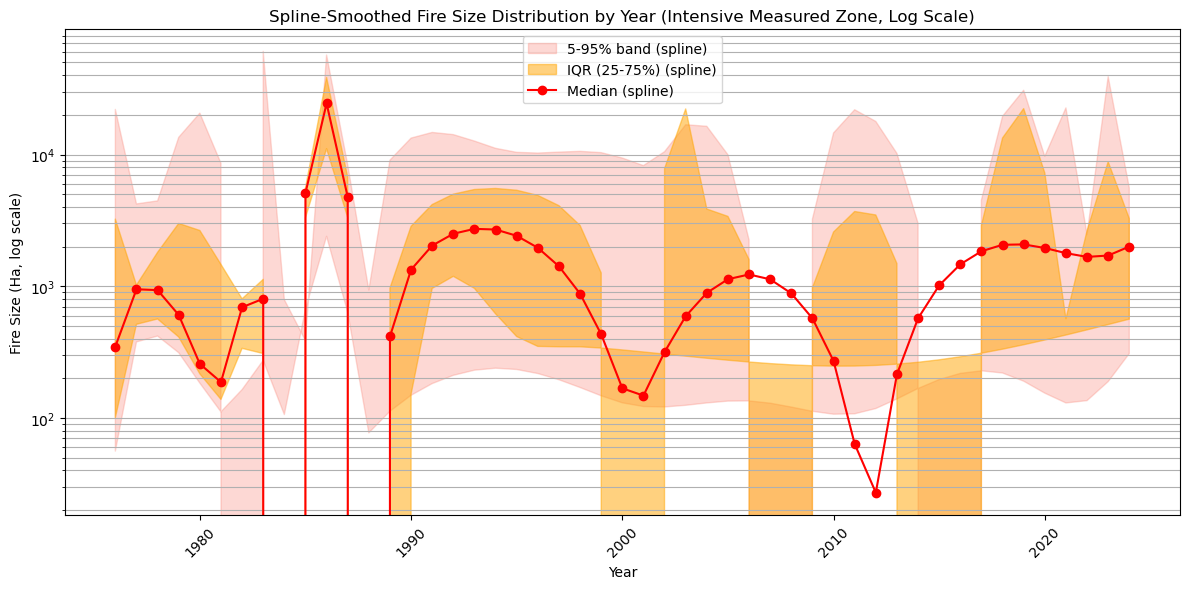

In [21]:
# Spline-smoothed 5-95% band, IQR, and median for Intensive Measured Zone
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Group by year and aggregate statistics
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Add zeroes for years with no fires
all_years = np.arange(intensive['YEAR'].min(), intensive['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

x = stats['YEAR'].values
spline_smooth = {}
for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    # Use a smoothing factor s; adjust as needed for smoothness
    spline = UnivariateSpline(x, y, s=len(x)*np.var(y)*0.2)
    spline_smooth[col] = spline(x)

plt.figure(figsize=(12, 6))
plt.fill_between(x, spline_smooth['p5'], spline_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (spline)')
plt.fill_between(x, spline_smooth['q25'], spline_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (spline)')
plt.plot(x, spline_smooth['median'], color='red', marker='o', label='Median (spline)')
plt.title('Spline-Smoothed Fire Size Distribution by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, spline_smooth['p5'], spline_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (spline)')
plt.fill_between(x, spline_smooth['q25'], spline_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (spline)')
plt.plot(x, spline_smooth['median'], color='red', marker='o', label='Median (spline)')
plt.title('Spline-Smoothed Fire Size Distribution by Year (Intensive Measured Zone, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

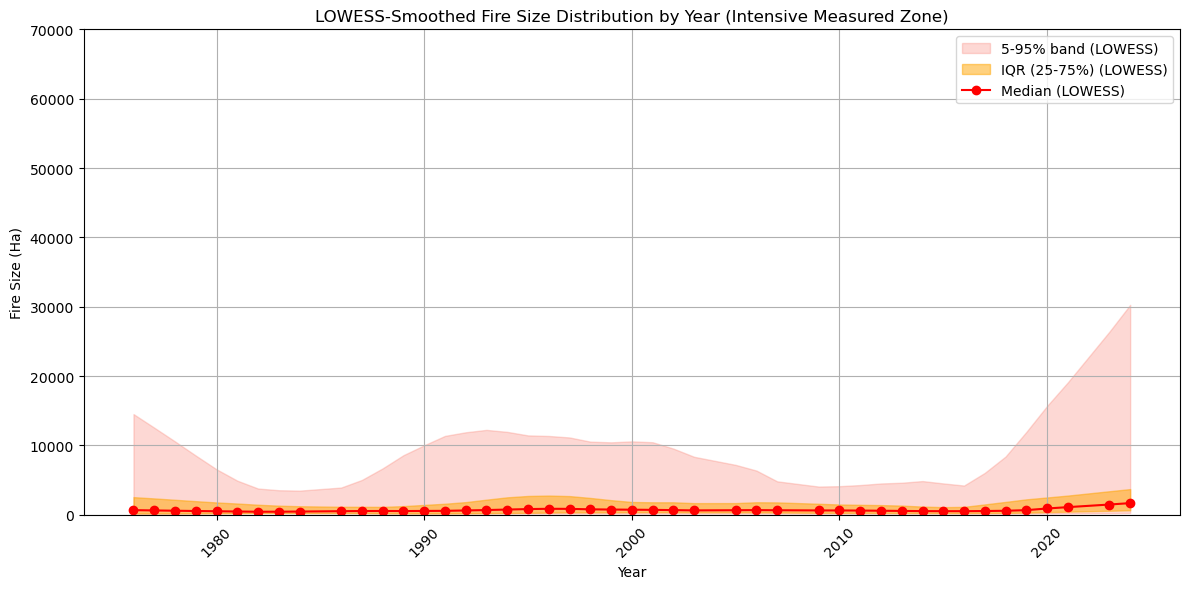

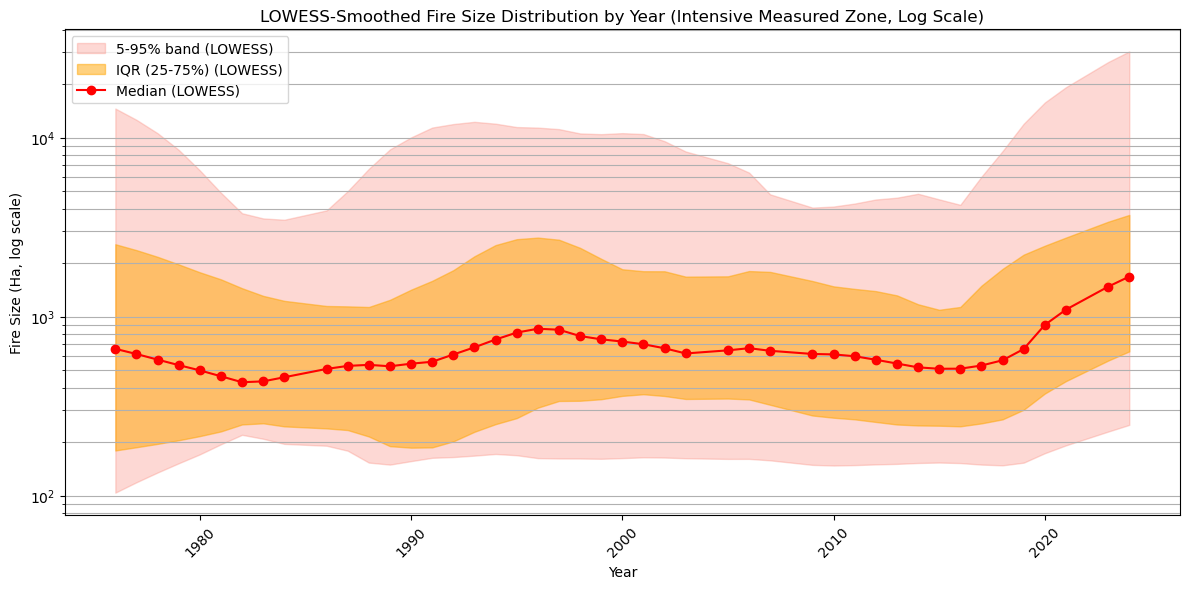

In [23]:
# LOWESS-smoothed 5-95% band, IQR, and median for Intensive Measured Zone (only years with data)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Group by year and aggregate statistics (only years with data)
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

x = stats['YEAR'].values
lowess_smooth = {}
frac = 0.25  # Smoothing parameter (adjust as needed)
for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    lowess_smooth[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Intensive Measured Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Intensive Measured Zone, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

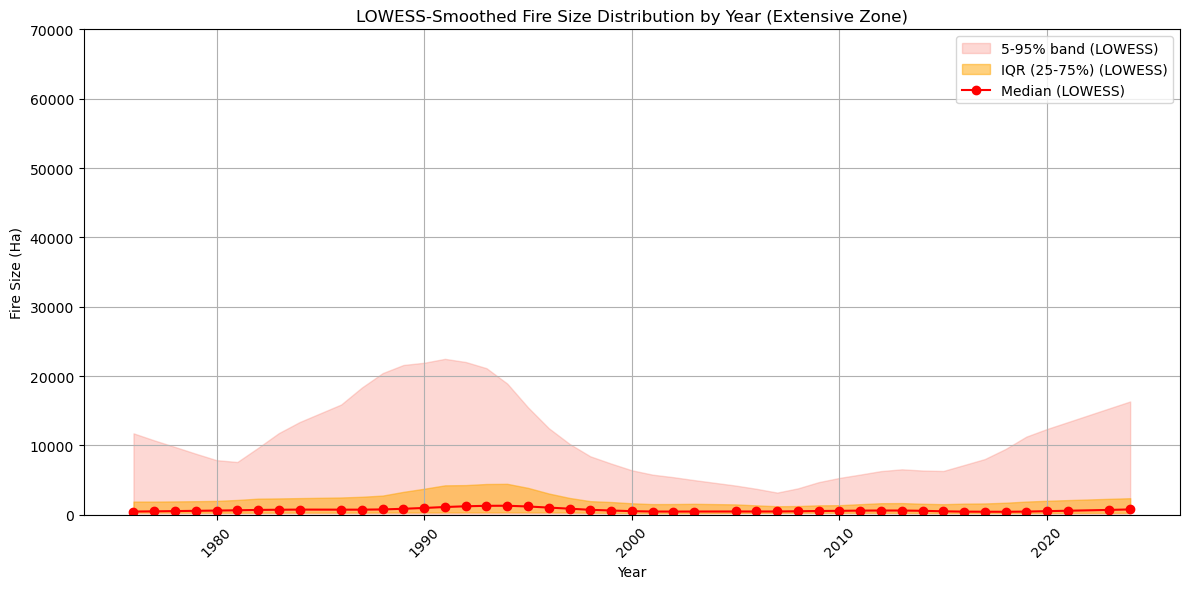

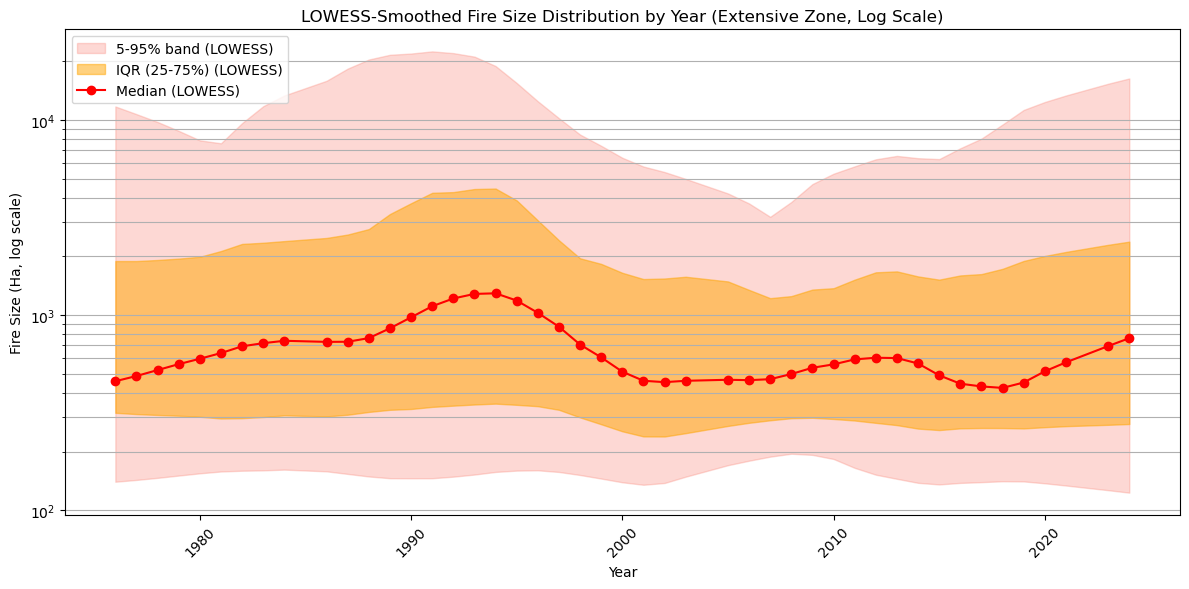

In [25]:
# LOWESS-smoothed 5-95% band, IQR, and median for Intensive Measured Zone (only years with data)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Group by year and aggregate statistics (only years with data)
stats = extensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

x = stats['YEAR'].values
lowess_smooth = {}
frac = 0.25  # Smoothing parameter (adjust as needed)
for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    lowess_smooth[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Extensive Zone)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Extensive Zone, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

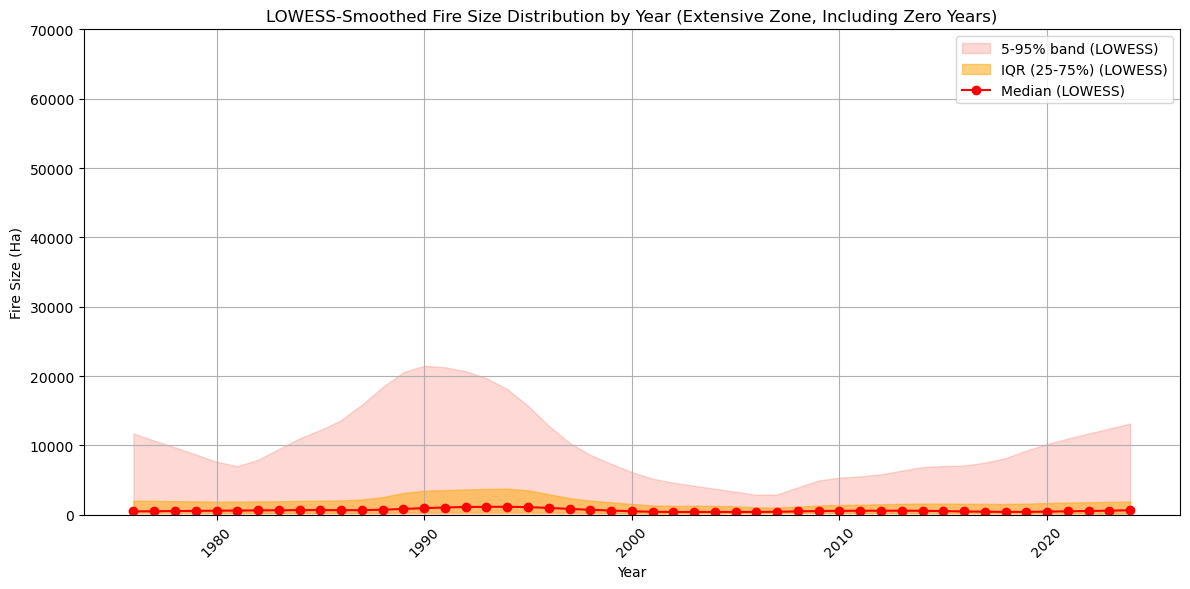

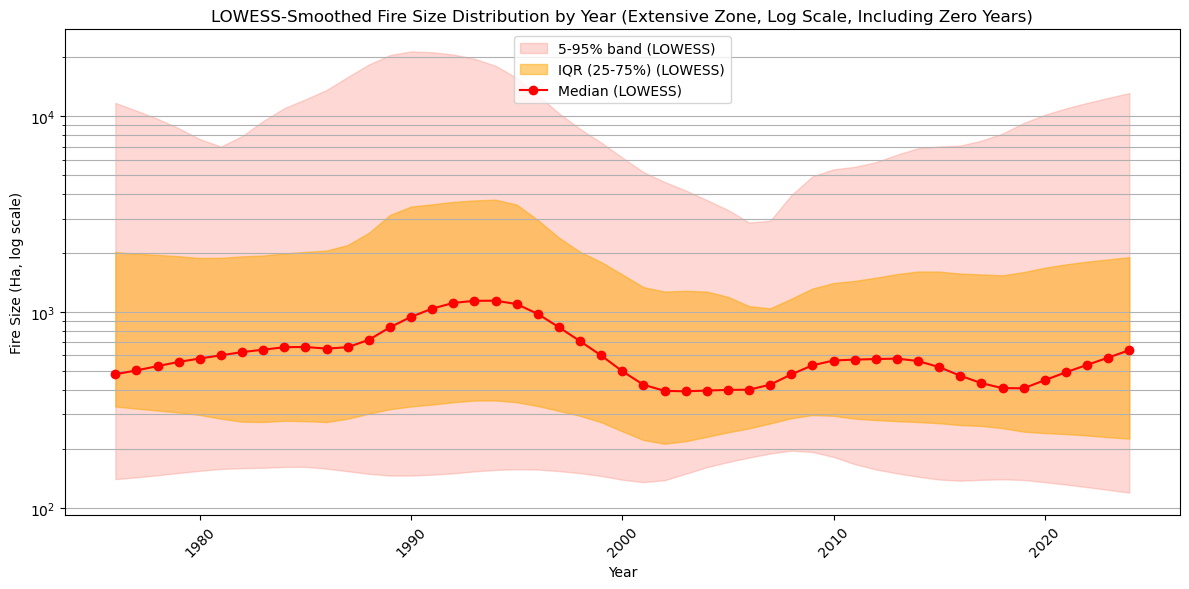

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Group by year and aggregate statistics (include zero years)
stats = extensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Fill in missing years with zeroes
all_years = np.arange(extensive['YEAR'].min(), extensive['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

x = stats['YEAR'].values
lowess_smooth = {}
frac = 0.25  # Smoothing parameter (adjust as needed)
for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    lowess_smooth[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Extensive Zone, Including Zero Years)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Extensive Zone, Log Scale, Including Zero Years)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

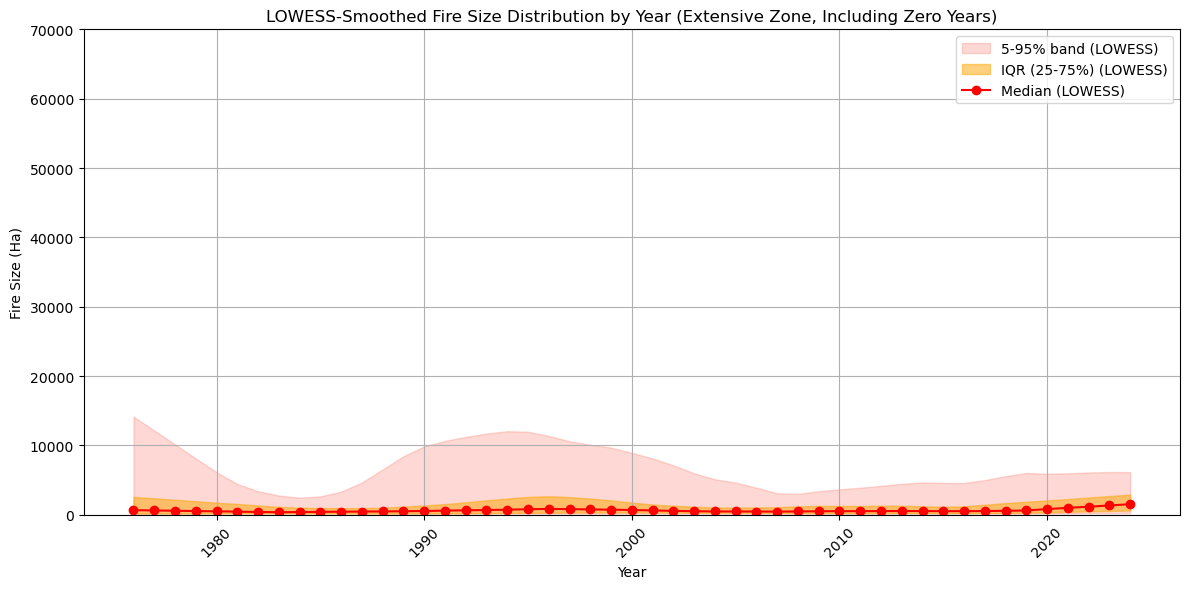

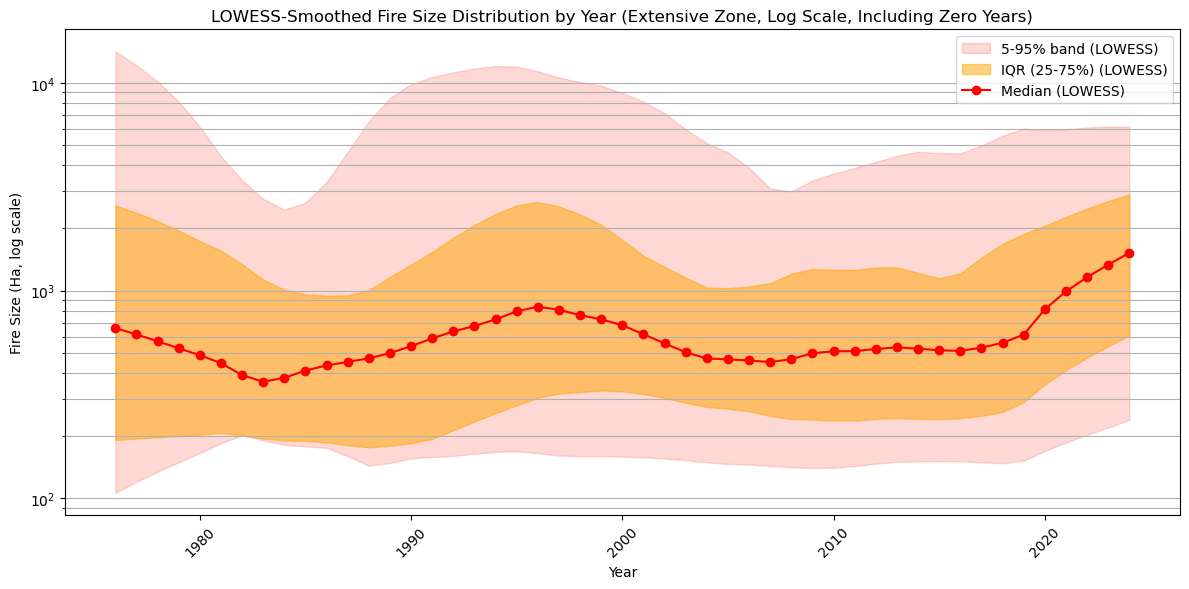

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Group by year and aggregate statistics (include zero years)
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Fill in missing years with zeroes
all_years = np.arange(extensive['YEAR'].min(), extensive['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

x = stats['YEAR'].values
lowess_smooth = {}
frac = 0.25  # Smoothing parameter (adjust as needed)
for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    lowess_smooth[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Extensive Zone, Including Zero Years)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Extensive Zone, Log Scale, Including Zero Years)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

In [29]:
stats

,YEAR,median,q25,q75,p5,p95
0,1976,570.599976,203.825001,3261.399963,117.865002,21347.190137
1,1977,391.299988,149.250004,973.749985,123.655001,6764.319946
2,1978,1250.250000,993.375000,1507.125000,787.875000,1712.625000
3,1979,621.199997,266.050011,3819.200012,131.500004,11826.925049
4,1980,404.700012,202.300003,2432.749939,156.790003,26626.299219
5,1981,283.300003,138.575001,854.924988,114.085000,3512.649957
6,1982,251.900002,246.350002,257.450001,241.910003,261.890000
7,1983,404.700012,161.899994,2565.699951,121.400002,60698.857813
8,1984,566.550003,515.974998,617.125008,475.514995,657.585011
9,1985,0.000000,0.000000,0.000000,0.000000,0.000000


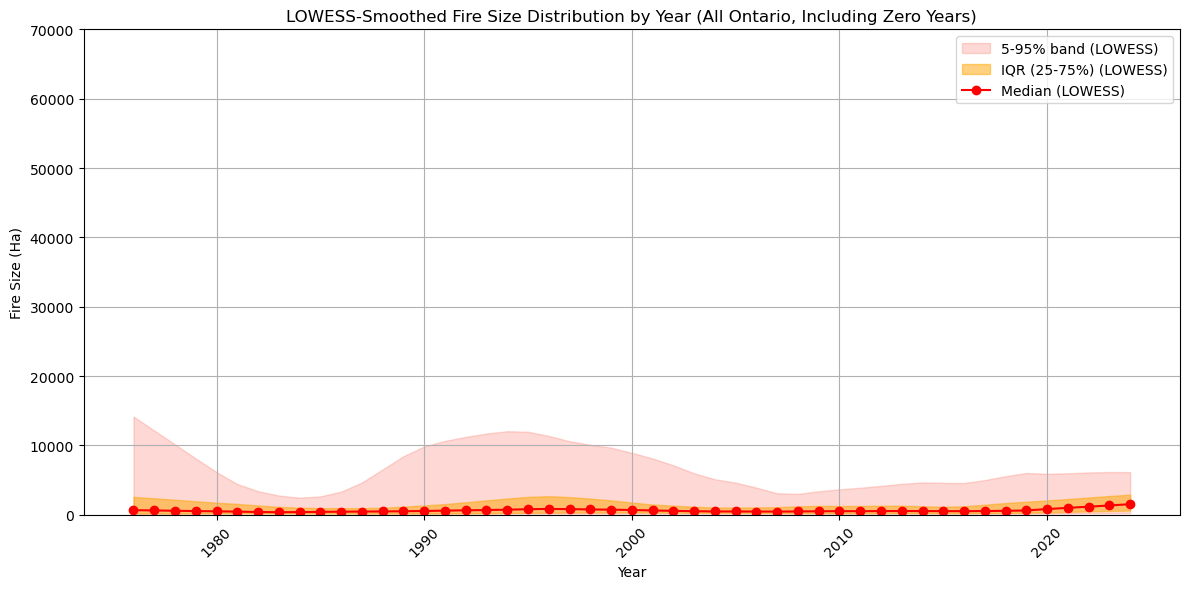

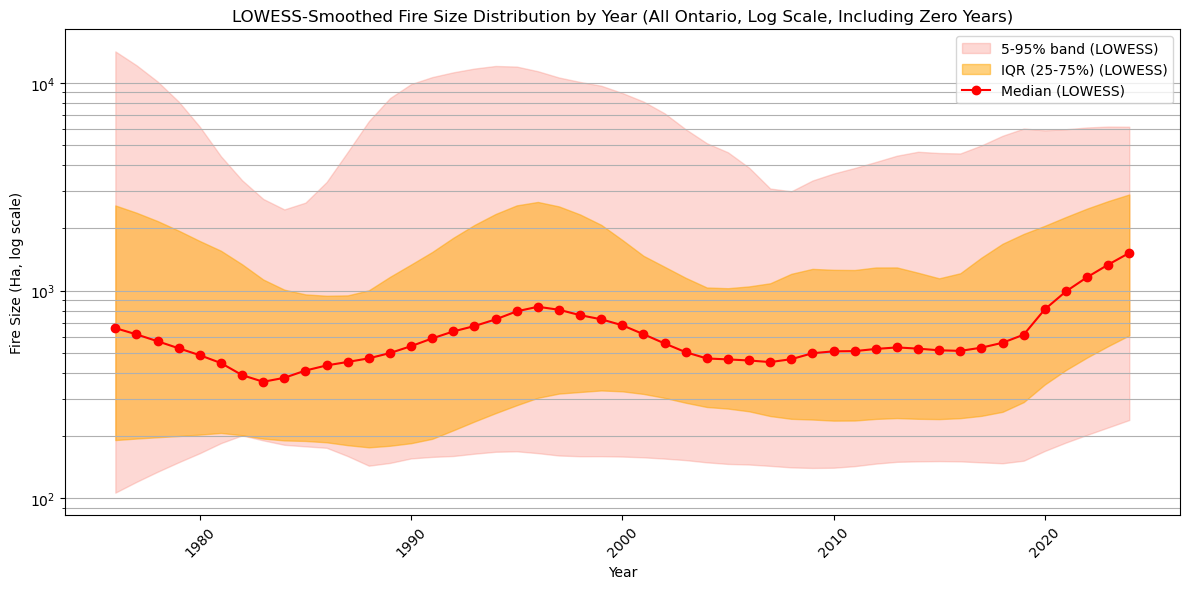

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Group by year and aggregate statistics (include zero years) for all Ontario (all_fires)
stats = intensive.groupby('YEAR')['SIZE_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

# Fill in missing years with zeroes
all_years = np.arange(all_fires['YEAR'].min(), all_fires['YEAR'].max() + 1)
stats = stats.set_index('YEAR').reindex(all_years).fillna(0).reset_index().rename(columns={'index': 'YEAR'})

x = stats['YEAR'].values
lowess_smooth = {}
frac = 0.25  # Smoothing parameter (adjust as needed)
for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    lowess_smooth[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (All Ontario, Including Zero Years)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha)')
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (All Ontario, Log Scale, Including Zero Years)')
plt.xlabel('Year')
plt.ylabel('Fire Size (Ha, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()